# BenchMAC Analysis V2

This notebook provides a comprehensive analysis of all BenchMAC experiments, including both successful and failed runs.

Unlike the first analysis notebook which only considered completed experiments, this version:
- Analyzes failed experiments and categorizes failure reasons
- Handles experiments with empty diffs (now treated as completed with zero metrics)
- Identifies missing experiments and evaluations
- Provides actionable recommendations for re-running experiments with adjusted limits

## Approach

1. Load all experiments and evaluations from disk
2. Compute experiment tasks as the Cartesian product: instances × agent_configs
3. Match each task to experiments and evaluations
4. Identify and categorize failures (steps limit, cost limit, other errors)
5. Filter out agent configs with excessive cost-related failures
6. Create final dataset: one experiment + evaluation per task
7. Perform analysis and visualization

## Setup and Imports

In [1]:
import json
from collections import Counter, defaultdict
from pathlib import Path

import pandas as pd
from pydantic import TypeAdapter

from bench_mac.core.models import (
    EvaluationCompleted,
    EvaluationFailed,
    EvaluationResult,
)
from experiments.models import (
    AgentConfig,
    CompletedExperiment,
    ExperimentResult,
    FailedExperiment,
    MiniSweAgentConfig,
)

## 1. Load All Experiments and Evaluations

In [2]:
# Configuration
BENCHMAC_DIR = Path("../.benchmac")
EXPERIMENTS_DIR = BENCHMAC_DIR / "experiments" / "results"
EVALUATIONS_DIR = BENCHMAC_DIR / "evaluations"
assert EXPERIMENTS_DIR.exists()
assert EVALUATIONS_DIR.exists()

# Instances to exclude from analysis
EXCLUDED_INSTANCES = {
    "akveo__ngx-admin_v15_to_v16",  # Known problematic instance
}

In [3]:
def load_experiments(
    experiments_dir: Path,
) -> tuple[list[CompletedExperiment], list[FailedExperiment]]:
    """Load all experiments from JSON files."""
    completed: list[CompletedExperiment] = []
    failed: list[FailedExperiment] = []

    for json_file in experiments_dir.rglob("*.json"):
        with json_file.open("r") as f:
            experiment = ExperimentResult.model_validate_json(f.read()).root

            match experiment:
                case CompletedExperiment():
                    completed.append(experiment)
                case FailedExperiment():
                    failed.append(experiment)

    return completed, failed


def load_evaluations(
    evaluations_dir: Path,
) -> tuple[list[EvaluationCompleted], list[EvaluationFailed]]:
    """Load all evaluations from JSONL files."""
    completed: list[EvaluationCompleted] = []
    failed: list[EvaluationFailed] = []

    eval_adapter = TypeAdapter(EvaluationResult)

    for jsonl_file in evaluations_dir.rglob("*.jsonl"):
        with jsonl_file.open("r") as f:
            for line in f:
                if line.strip():
                    eval_result = eval_adapter.validate_python(json.loads(line))
                    match eval_result:
                        case EvaluationCompleted():
                            completed.append(eval_result)
                        case EvaluationFailed():
                            failed.append(eval_result)

    return completed, failed

In [4]:
# Load all data
print("Loading experiments...")
completed_experiments, failed_experiments = load_experiments(EXPERIMENTS_DIR)

print("Loading evaluations...")
completed_evaluations, failed_evaluations = load_evaluations(EVALUATIONS_DIR)

print(f"\nLoaded {len(completed_experiments)} completed experiments")
print(f"Loaded {len(failed_experiments)} failed experiments")
print(f"Loaded {len(completed_evaluations)} completed evaluations")
print(f"Loaded {len(failed_evaluations)} failed evaluations")

Loading experiments...
Loading evaluations...

Loaded 168 completed experiments
Loaded 35 failed experiments
Loaded 172 completed evaluations
Loaded 0 failed evaluations


## 2. Initial Filtering and Statistics

In [5]:
# Filter out excluded instances
completed_experiments = [
    e for e in completed_experiments if e.task.instance_id not in EXCLUDED_INSTANCES
]
failed_experiments = [
    e for e in failed_experiments if e.task.instance_id not in EXCLUDED_INSTANCES
]

print("After filtering excluded instances:")
print(f"  {len(completed_experiments)} completed experiments")
print(f"  {len(failed_experiments)} failed experiments")

After filtering excluded instances:
  168 completed experiments
  35 failed experiments


In [6]:
# Count experiments with empty diffs
empty_diff_experiments = [
    e for e in completed_experiments if e.submission.model_patch == ""
]

print(f"\nExperiments with empty diffs: {len(empty_diff_experiments)}")


Experiments with empty diffs: 7


## 3. Extract Unique Instances and Agent Configs

In [7]:
# Extract unique instances
all_instance_ids = {
    exp.task.instance_id for exp in completed_experiments + failed_experiments
}

instance_ids = sorted(all_instance_ids)

print(f"Found {len(instance_ids)} unique benchmark instances:")
for iid in instance_ids:
    print(f"  - {iid}")

Found 9 unique benchmark instances:
  - gothinkster__angular-realworld-example-app_v11_to_v12
  - gothinkster__angular-realworld-example-app_v12_to_v13
  - gothinkster__angular-realworld-example-app_v13_to_v14
  - gothinkster__angular-realworld-example-app_v14_to_v15
  - gothinkster__angular-realworld-example-app_v15_to_v16
  - gothinkster__angular-realworld-example-app_v16_to_v17
  - gothinkster__angular-realworld-example-app_v17_to_v18
  - gothinkster__angular-realworld-example-app_v18_to_v19
  - gothinkster__angular-realworld-example-app_v19_to_v20


In [8]:
# Extract unique agent configs
type AgentConfigKey = str
agent_configs_dict: dict[AgentConfigKey, AgentConfig] = {}

for exp in completed_experiments + failed_experiments:
    config = exp.task.agent_config
    key = config.key
    if key not in agent_configs_dict:
        agent_configs_dict[key] = config

agent_configs = sorted(agent_configs_dict.values(), key=lambda x: x.key)

print(f"\nFound {len(agent_configs)} unique agent configurations:")
for ac in agent_configs:
    print(f"  - {ac.key}")
    if isinstance(ac, MiniSweAgentConfig):
        print(f"    - {ac.model_name}")
        model_kwargs = ac.model_kwargs
        if model_kwargs:
            print(f"    - {model_kwargs}")


Found 21 unique agent configurations:
  - angular-schematics/789e301f
  - swe-agent-mini/anthropic/claude-opus-4-1-20250805@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
    - anthropic/claude-opus-4-1-20250805
    - {'temperature': 0.0}
  - swe-agent-mini/anthropic/claude-sonnet-4-20250514@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
    - anthropic/claude-sonnet-4-20250514
    - {'temperature': 0.0}
  - swe-agent-mini/anthropic/claude-sonnet-4-5-20250929@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
    - anthropic/claude-sonnet-4-5-20250929
    - {'temperature': 0.0}
  - swe-agent-mini/gemini/gemini-2.5-flash-lite@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
    - gemini/gemini-2.5-flash-lite
    - {'temperature': 0.0}
  - swe-agent-mini/gemini/gemini-2.5-flash@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
    - gemini/gemini-2

## 4. Compute Experiment Tasks and Match to Results

In [9]:
# Compute all possible experiment tasks (Cartesian product)
from experiments.models import ExperimentTask

experiment_tasks = [
    ExperimentTask(instance_id=instance_id, agent_config=agent_config)
    for instance_id in instance_ids
    for agent_config in agent_configs
]

print(f"Total experiment tasks: {len(experiment_tasks)}")
print(f"  = {len(instance_ids)} instances × {len(agent_configs)} agent configs")  # noqa: RUF001

Total experiment tasks: 189
  = 9 instances × 21 agent configs


In [10]:
# Group experiments by task
experiments_by_task: dict[
    ExperimentTask, list[FailedExperiment | CompletedExperiment]
] = defaultdict(list)

for exp in completed_experiments:
    task = ExperimentTask(
        instance_id=exp.task.instance_id, agent_config=exp.task.agent_config
    )
    experiments_by_task[task].append(exp)

for exp in failed_experiments:
    task = ExperimentTask(
        instance_id=exp.task.instance_id, agent_config=exp.task.agent_config
    )
    experiments_by_task[task].append(exp)

assert sum(len(exps) for exps in experiments_by_task.values()) == len(
    completed_experiments
) + len(failed_experiments)

In [11]:
# Analyze task coverage
tasks_with_no_experiments = [
    task
    for task in experiment_tasks
    if task not in experiments_by_task or not experiments_by_task[task]
]

tasks_with_multiple_experiments = [
    (task, len(experiments_by_task[task]))
    for task in experiment_tasks
    if len(experiments_by_task[task]) > 1
]

print(f"\nTasks with 0 experiments: {len(tasks_with_no_experiments)}")
if tasks_with_no_experiments:
    print("  Consider running these experiments:")
    for task in tasks_with_no_experiments[:5]:  # Show first 5
        print(f"    - {task.instance_id} with {task.agent_config.key}")
    if len(tasks_with_no_experiments) > 5:
        print(f"    ... and {len(tasks_with_no_experiments) - 5} more")

print(f"\nTasks with >1 experiments: {len(tasks_with_multiple_experiments)}")
if tasks_with_multiple_experiments:
    print("  (This is not a problem - we keep the latest completed experiment)")
    for task, count in tasks_with_multiple_experiments:
        print(
            f"    - {task.instance_id} with {task.agent_config.key}: {count} experiments"
        )
        failed, completed = (
            [e for e in experiments_by_task[task] if isinstance(e, FailedExperiment)],
            [
                e
                for e in experiments_by_task[task]
                if isinstance(e, CompletedExperiment)
            ],
        )
        print(f"      - {len(failed)} failed, {len(completed)} completed")


Tasks with 0 experiments: 0

Tasks with >1 experiments: 12
  (This is not a problem - we keep the latest completed experiment)
    - gothinkster__angular-realworld-example-app_v11_to_v12 with swe-agent-mini/anthropic/claude-opus-4-1-20250805@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc: 2 experiments
      - 2 failed, 0 completed
    - gothinkster__angular-realworld-example-app_v11_to_v12 with swe-agent-mini/gemini/gemini-2.5-flash-lite@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc: 2 experiments
      - 1 failed, 1 completed
    - gothinkster__angular-realworld-example-app_v11_to_v12 with swe-agent-mini/mistral/devstral-small-2507@modelkw-2b574f61@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc: 2 experiments
      - 2 failed, 0 completed
    - gothinkster__angular-realworld-example-app_v11_to_v12 with swe-agent-mini/mistral/magistral-small-2509@modelkw-813f7a1c@minisweagent-1.13.0@tasktpl-73947524@agentsettin

## 5. Analyze Failed Experiments

In [12]:
from typing import cast

# Find tasks with only failed experiments
tasks_with_only_failures: list[tuple[ExperimentTask, list[FailedExperiment]]] = []

for task in experiment_tasks:
    if task not in experiments_by_task:
        continue

    exps = experiments_by_task[task]
    if not exps:
        print(f"Task {(task.instance_id, task.agent_config.key)} has no experiments")
        continue

    if all(isinstance(e, FailedExperiment) for e in exps):
        tasks_with_only_failures.append((task, cast(list[FailedExperiment], exps)))

print(f"Tasks with only failed experiments: {len(tasks_with_only_failures)}")

Tasks with only failed experiments: 23


In [13]:
STEP_LIMIT_MULTIPLE = 100  # ⚠️⚠️⚠️⚠️ Assuming step limit is a multiple of that ⚠️⚠️⚠️⚠️⚠️


# Categorize failure reasons
def categorize_failure(exp: FailedExperiment) -> str:
    """Categorize the reason for experiment failure."""

    # Check if steps limit was exceeded
    if (
        "LimitsExceeded" in exp.error
        and exp.artifacts
        and exp.artifacts.execution_trace
    ):
        num_steps = len(exp.artifacts.execution_trace.steps)
        if num_steps % STEP_LIMIT_MULTIPLE == 0:
            return "steps_limit_exceeded"

    # Check error message for cost-related failures
    if "LimitsExceeded" in exp.error:
        return (
            "cost_limit_exceeded"  # Assume if it's not a step limit, it's a cost limit
        )

    return "other_error"


failure_categories = Counter()
failures_by_category: dict[str, list[tuple[ExperimentTask, FailedExperiment]]] = (
    defaultdict(list)
)  # category -> list[(task, FailedExperiment)]

for task, exps in tasks_with_only_failures:
    latest_failure = max(exps, key=lambda e: e.ended_at)
    category = categorize_failure(latest_failure)
    failure_categories[category] += 1
    failures_by_category[category].append((task, latest_failure))

print("\nFailure categories:")
for category, count in failure_categories.most_common():
    print(f"  {category}: {count}")


Failure categories:
  steps_limit_exceeded: 14
  cost_limit_exceeded: 9


## 6. Handle Cost Limit Failures

Rule:
- If more than X percent of an agent config's runs exceeded the cost limit, discard all runs from that agent
- For remaining cost-exceeded runs, provide recommendations to re-run with higher limits

In [14]:
# Set the threshold for discarding agents due to cost failures
COST_FAILURE_DISCARD_THRESHOLD_PERCENT = 33

# Count cost failures per agent config
cost_failures_by_agent = defaultdict(int)
total_runs_by_agent = defaultdict(int)

for task in experiment_tasks:
    agent_key = task.agent_config.key
    total_runs_by_agent[agent_key] += 1

    if task in experiments_by_task:
        exps = experiments_by_task[task]
        latest = max(
            exps, key=lambda e: e.ended_at if hasattr(e, "ended_at") else e.started_at
        )

        if (
            isinstance(latest, FailedExperiment)
            and categorize_failure(latest) == "cost_limit_exceeded"
        ):
            cost_failures_by_agent[agent_key] += 1

# Identify agents to discard (>COST_FAILURE_DISCARD_THRESHOLD_PERCENT% cost failures)
agents_to_discard: set[AgentConfigKey] = set()
agents_needing_rerun: dict[AgentConfigKey, int] = {}

for agent_key in total_runs_by_agent:
    total = total_runs_by_agent[agent_key]
    cost_fails = cost_failures_by_agent[agent_key]

    if (
        total > 0
        and (cost_fails / total * 100) > COST_FAILURE_DISCARD_THRESHOLD_PERCENT
    ):
        agents_to_discard.add(agent_key)
    elif cost_fails > 0:
        agents_needing_rerun[agent_key] = cost_fails

print(
    f"Agent configs to discard (>{COST_FAILURE_DISCARD_THRESHOLD_PERCENT}% cost failures): {len(agents_to_discard)}"
)
for agent_key in agents_to_discard:
    total = total_runs_by_agent[agent_key]
    cost_fails = cost_failures_by_agent[agent_key]
    print(
        f"  {agent_key[:60]}...: {cost_fails}/{total}={cost_fails / total * 100:2.0f}% failures"
    )

print(
    f"\nAgent configs needing re-runs (some cost failures): {len(agents_needing_rerun)}"
)
for agent_key, count in agents_needing_rerun.items():
    print(f"  {agent_key[:60]}...: {count} failures")
    # Show the actual tasks for this agent_key that failed due to cost
    failed_tasks = [
        task
        for task in experiment_tasks
        if task.agent_config.key == agent_key
        and task in experiments_by_task
        and any(
            isinstance(exp, FailedExperiment)
            and categorize_failure(exp) == "cost_limit_exceeded"
            for exp in experiments_by_task[task]
        )
    ]
    for task in failed_tasks:
        print(f"    - Task instance_id: {task.instance_id}")

Agent configs to discard (>33% cost failures): 2
  swe-agent-mini/anthropic/claude-opus-4-1-20250805@modelkw-91...: 5/9=56% failures
  swe-agent-mini/xai/grok-4-0709@modelkw-916a2d40@minisweagent...: 4/9=44% failures

Agent configs needing re-runs (some cost failures): 0


In [15]:
# Show specific instances that need re-running with higher cost limits
if agents_needing_rerun:
    print("\n" + "=" * 80)
    print("ACTION REQUIRED: Re-run these experiments with higher cost limits")
    print("=" * 80)

    for task, _exp in failures_by_category["cost_limit_exceeded"]:
        agent_key = task.agent_config.key
        if agent_key not in agents_to_discard:
            print(f"\nInstance: {task.instance_id}")
            print(f"Agent config: {agent_key}")

    print("\n" + "=" * 80)
    print("After re-running, return to this notebook to continue analysis.")
    print("=" * 80)

## 7. Create Final Dataset: One Experiment Per Task

For each experiment task, we select the latest completed experiment (if available).
Tasks with only failed experiments or from discarded agents are excluded.

In [16]:
# Filter out discarded agents
valid_tasks = [
    task for task in experiment_tasks if task.agent_config.key not in agents_to_discard
]
agent_configs = sorted(
    [ac for ac in agent_configs if ac.key not in agents_to_discard], key=lambda x: x.key
)
assert set(agent_configs) == {task.agent_config for task in valid_tasks}

print(f"Valid tasks after filtering: {len(valid_tasks)}")
print(
    f"  (Removed {len(experiment_tasks) - len(valid_tasks)} tasks from {len(agents_to_discard)} discarded agents)"
)
# Show final number of agent configs
print(f"Final number of agent configs: {len(agent_configs)}")
for ac in agent_configs:
    print(f"  - {ac.key}")

Valid tasks after filtering: 171
  (Removed 18 tasks from 2 discarded agents)
Final number of agent configs: 19
  - angular-schematics/789e301f
  - swe-agent-mini/anthropic/claude-sonnet-4-20250514@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
  - swe-agent-mini/anthropic/claude-sonnet-4-5-20250929@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
  - swe-agent-mini/gemini/gemini-2.5-flash-lite@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
  - swe-agent-mini/gemini/gemini-2.5-flash@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
  - swe-agent-mini/gemini/gemini-2.5-pro@modelkw-06f54fcf@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
  - swe-agent-mini/mistral/devstral-medium-2507@modelkw-2b574f61@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc
  - swe-agent-mini/mistral/devstral-small-2507@modelkw-2b574f61@minisweagent-1.13.0@tasktpl-73947524@age

In [17]:
# Map each valid task to its latest completed experiment
task_to_experiment: dict[ExperimentTask, CompletedExperiment | FailedExperiment] = {}

for task in valid_tasks:
    task_pretty = f"{task.instance_id} with {task.agent_config.key}"
    if task not in experiments_by_task:
        print(f"Task {task_pretty} not found in experiments_by_task")
        continue
    exps = experiments_by_task[task]
    if not exps:
        print(f"Task {task_pretty} has no experiments")
        continue

    failed = sorted(
        [e for e in exps if isinstance(e, FailedExperiment)], key=lambda e: e.ended_at
    )
    completed = sorted(
        [e for e in exps if isinstance(e, CompletedExperiment)],
        key=lambda e: e.ended_at,
    )
    if not completed:
        print(
            f"Task {task_pretty} has no completed experiments, so we assign the latest failed experiment"
        )
        assert len(failed) >= 1
        exp = failed[-1]
        execution_trace = (
            exp.artifacts.execution_trace
            if exp.artifacts and exp.artifacts.execution_trace
            else None
        )
        num_steps = len(execution_trace.steps) if execution_trace else None
        print(f"  Failed experiment: {exp.error} (num_steps: {num_steps})")
    else:
        exp = completed[-1]

    # Keep latest completed experiment
    task_to_experiment[task] = exp

print(f"\nTasks mapped to experiments: {len(task_to_experiment)}")

Task gothinkster__angular-realworld-example-app_v11_to_v12 with swe-agent-mini/mistral/devstral-small-2507@modelkw-2b574f61@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc has no completed experiments, so we assign the latest failed experiment
  Failed experiment: Mini SWE Agent stopped before submission: LimitsExceeded:  (num_steps: 100)
Task gothinkster__angular-realworld-example-app_v12_to_v13 with swe-agent-mini/mistral/devstral-small-2507@modelkw-2b574f61@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc has no completed experiments, so we assign the latest failed experiment
  Failed experiment: Mini SWE Agent stopped before submission: LimitsExceeded:  (num_steps: 100)
Task gothinkster__angular-realworld-example-app_v13_to_v14 with swe-agent-mini/mistral/mistral-small-2506@modelkw-7322c1f7@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc has no completed experiments, so we assign the latest failed experiment
  Failed experiment: Mini SWE Agent sto

## 8. Match Experiments to Evaluations

In [18]:
# Group evaluations by submission ID
from bench_mac.core.models import SubmissionID

evaluations_by_submission: dict[SubmissionID, list[EvaluationResult]] = defaultdict(
    list
)

for eval_result in completed_evaluations:
    evaluations_by_submission[eval_result.result.submission_id].append(eval_result)

for eval_result in failed_evaluations:
    evaluations_by_submission[eval_result.submission_id].append(eval_result)

assert len(evaluations_by_submission) == len(completed_evaluations) + len(
    failed_evaluations
)

In [19]:
# Match each experiment to evaluations
task_to_evaluation: dict[ExperimentTask, EvaluationResult] = {}
tasks_without_evaluation: list[ExperimentTask] = []
tasks_with_only_failed_evals: dict[ExperimentTask, list[EvaluationFailed]] = (
    defaultdict(list)
)

for task, exp in task_to_experiment.items():
    match exp:
        case CompletedExperiment():
            submission_id = exp.submission.submission_id
        case FailedExperiment():
            # FailedExperiments have no submission
            continue

    if (
        submission_id not in evaluations_by_submission
        or not evaluations_by_submission[submission_id]
    ):
        tasks_without_evaluation.append(task)
        continue

    evals = evaluations_by_submission[submission_id]
    assert len(evals) > 0

    completed_evals = [e for e in evals if isinstance(e, EvaluationCompleted)]
    failed_evals = [e for e in evals if isinstance(e, EvaluationFailed)]

    if not completed_evals:
        tasks_with_only_failed_evals[task] = failed_evals
        continue

    # Keep latest completed evaluation
    latest_eval = max(completed_evals, key=lambda e: e.ended_at)
    task_to_evaluation[task] = latest_eval

print(f"Tasks with completed evaluations: {len(task_to_evaluation)}")
print(f"Tasks without any evaluation: {len(tasks_without_evaluation)}")
print(f"Tasks with only failed evaluations: {len(tasks_with_only_failed_evals)}")

Tasks with completed evaluations: 157
Tasks without any evaluation: 0
Tasks with only failed evaluations: 0


In [20]:
# Show failed evaluation errors
if tasks_with_only_failed_evals:
    print("\nFailed evaluations:")
    for task, evals in tasks_with_only_failed_evals.items():
        task_pretty = f"{task.instance_id} with {task.agent_config.key}"
        print(f"  {task_pretty}:")
        for eval in evals:
            print(f"    - {eval.error}")
        print()

In [21]:
# Prompt user to run missing evaluations
if tasks_without_evaluation or tasks_with_only_failed_evals:
    print("\n" + "=" * 80)
    print("ACTION REQUIRED: Run evaluations for experiments")
    print("=" * 80)
    print("\nRun: uv run benchmac eval")
    print(
        f"\nMissing evaluations: {len(tasks_without_evaluation) + len(tasks_with_only_failed_evals)}"
    )
    print("=" * 80)

In [22]:
EvaluatedExperiment = tuple[CompletedExperiment, EvaluationCompleted]
data: dict[ExperimentTask, FailedExperiment | EvaluatedExperiment] = {}

for task in valid_tasks:
    match task_to_experiment[task]:
        case CompletedExperiment():
            exp = task_to_experiment[task]
            eval = task_to_evaluation[task]
            assert isinstance(exp, CompletedExperiment)
            assert isinstance(eval, EvaluationCompleted)
            data[task] = (exp, eval)
        case FailedExperiment():
            exp = task_to_experiment[task]
            assert isinstance(exp, FailedExperiment)
            data[task] = exp

assert not any(task in data for task in tasks_without_evaluation)
assert not any(task in data for task in tasks_with_only_failed_evals)

tasks = list(data.keys())
experiments = [x if isinstance(x, FailedExperiment) else x[0] for x in data.values()]
failed_experiments = [x for x in experiments if isinstance(x, FailedExperiment)]
completed_experiments = [x for x in experiments if isinstance(x, CompletedExperiment)]
evaluations = [x[1] for x in data.values() if isinstance(x, tuple)]

In [23]:
from collections import defaultdict

# Group data by agent_config.key
grouped_by_agent: dict[str, list[FailedExperiment | EvaluatedExperiment]] = defaultdict(
    list
)
for task, result in data.items():
    agent_key = task.agent_config.key
    grouped_by_agent[agent_key].append(result)

assert all(len(results) == len(instance_ids) for results in grouped_by_agent.values())

At this point, we have successfully matched experiment tasks to their results

## Next Steps

From here, we can proceed with:
- Computing success metrics and outcome categories
- Analyzing patch characteristics
- Creating leaderboards and visualizations
- Detecting execution loops in failed experiments

# Analysis

Now that we loaded and prepared all the data, what do we want to analyze ?
Some open questions:

- What models are the best ? Worst ? 
- What models are the most token efficient
- What models are the most step efficient
- What models are the fastest/slowest ?
- What models are the most expensive, what are the cheapest ? 
  Looking at the price per token of models is not enough because:
    Cheap per-token reasoning models can be more expensive than expensive per-token non-reasoning models, since reasoning models can generate way more tokens than non-reasoning models.
    Some models might take more steps than others for the same task. 
    In essence, because we can't predict the amount of tokens generated by the models, we need a more reliable metric for cost. One metric could be the average cost per instance. 
    But it wouldn't give us an idea of the cost/performance ratio. 

dataframe construction


evaluation metrics coming from the evaluation

percentage of steps suceeded

number of steps


## 9. Build Analysis Dataset

To enable downstream tables and leaderboards we consolidate the `data` mapping
into a tabular structure that keeps one row per `(instance_id, agent_config)`
pair and captures experiment/evaluation outcomes side by side.



In [24]:
from typing import Any


def _get_agent_display(agent_config: AgentConfig) -> str:
    """Return a human-friendly label for the agent configuration."""

    if isinstance(agent_config, MiniSweAgentConfig):
        return agent_config.model_name
    return agent_config.display_name


def _extract_experiment_common(
    experiment: CompletedExperiment | FailedExperiment,
) -> dict[str, Any]:
    """Collect fields shared by completed and failed experiments."""

    artifacts = experiment.artifacts
    execution_trace = artifacts.execution_trace if artifacts else None
    step_count = len(execution_trace.steps) if execution_trace else None
    scaffold = experiment.task.agent_config.scaffold
    match scaffold:
        case "swe-agent-mini":
            experiment_cost_usd = artifacts.cost_usd if artifacts else None
        case "angular-schematics":
            experiment_cost_usd = (
                artifacts.cost_usd
                if (artifacts and artifacts.cost_usd is not None)
                else 0.0
            )
        case _:
            raise ValueError(f"Unknown scaffold: {scaffold}")

    return {
        "experiment_id": experiment.id,
        "experiment_started_at": experiment.started_at,
        "experiment_ended_at": experiment.ended_at,
        "experiment_duration_seconds": experiment.duration.total_seconds(),
        "experiment_cost_usd": experiment_cost_usd,
        "experiment_n_calls": artifacts.n_calls if artifacts else None,
        "experiment_step_count": step_count,
    }


records: list[dict[str, Any]] = []

for task, result in data.items():
    agent_cfg = task.agent_config
    base: dict[str, Any] = {
        "instance_id": task.instance_id,
        "agent_key": agent_cfg.key,
        "agent_display_name": _get_agent_display(agent_cfg),
        "agent_scaffold": agent_cfg.scaffold,
    }

    if isinstance(result, FailedExperiment):
        record = {
            **base,
            "experiment_status": "failed",
            "failure_category": categorize_failure(result),
            "submission_id": None,
            "empty_diff": None,
            "evaluation_status": None,
            "evaluation_id": None,
            "patch_application_success": None,
            "install_success": None,
            "build_success": None,
            "target_version_achieved": None,
            "install_success_effective": False,
            "target_version_achieved_effective": False,
            "build_success_effective": False,
        }
        record.update(_extract_experiment_common(result))
        records.append(record)
        continue

    experiment, evaluation = result
    metrics = evaluation.result.metrics

    record = {
        **base,
        "experiment_status": "completed",
        "failure_category": None,
        "submission_id": experiment.submission.submission_id,
        "empty_diff": experiment.submission.model_patch.strip() == "",
        "evaluation_status": "completed",
        "evaluation_id": evaluation.id,
        "patch_application_success": metrics.patch_application_success,
        "install_success": metrics.install_success,
        "target_version_achieved": metrics.target_version_achieved,
        "build_success": metrics.build_success,
        "install_success_effective": metrics.install_success_effective,
        "target_version_achieved_effective": metrics.target_version_achieved_effective,
        "build_success_effective": metrics.build_success_effective,
    }
    record.update(_extract_experiment_common(experiment))
    records.append(record)

df = (
    pd.DataFrame.from_records(records)
    .sort_values(["instance_id", "agent_key"])
    .reset_index(drop=True)
)

df.head()

,instance_id,agent_key,agent_display_name,agent_scaffold,experiment_status,failure_category,submission_id,empty_diff,evaluation_status,evaluation_id,...,install_success_effective,target_version_achieved_effective,build_success_effective,experiment_id,experiment_started_at,experiment_ended_at,experiment_duration_seconds,experiment_cost_usd,experiment_n_calls,experiment_step_count
0,gothinkster__angular-realworld-example-app_v11...,angular-schematics/789e301f,angular-schematics/789e301f,angular-schematics,completed,None,0199a233-1775-71a6-8535-6ebf930e8d18,False,completed,0199a24b-d760-7d66-b2a0-bc006af02001,...,True,True,True,0199a234-d846-7691-b5e0-ca263098ab3c,2025-10-01 23:54:41.416522+00:00,2025-10-01 23:56:36.294169+00:00,114.877647,0.000000,NaN,2
1,gothinkster__angular-realworld-example-app_v11...,swe-agent-mini/anthropic/claude-sonnet-4-20250...,anthropic/claude-sonnet-4-20250514,swe-agent-mini,completed,None,0199a45b-a964-757e-9fc8-6524883b29da,False,completed,0199a76a-55ce-7684-9dd2-dc3e09760e18,...,True,True,True,0199a482-1814-782f-8f4f-38d3502d7fc1,2025-10-02 10:32:46.782699+00:00,2025-10-02 10:40:13.332620+00:00,446.549921,0.920712,29.0,29
2,gothinkster__angular-realworld-example-app_v11...,swe-agent-mini/anthropic/claude-sonnet-4-5-202...,anthropic/claude-sonnet-4-5-20250929,swe-agent-mini,completed,None,0199a45b-a965-7cad-81e6-5a240a9eb661,False,completed,0199a76e-dd8d-7726-844f-bce9d3e0f941,...,True,True,True,0199a488-eff6-74a8-be73-329999a5b8da,2025-10-02 10:40:15.917242+00:00,2025-10-02 10:47:41.814046+00:00,445.896804,0.552558,20.0,20
3,gothinkster__angular-realworld-example-app_v11...,swe-agent-mini/gemini/gemini-2.5-flash-lite@mo...,gemini/gemini-2.5-flash-lite,swe-agent-mini,completed,None,0199a90c-ed54-78d2-8916-96c6d2db864f,False,completed,0199a99e-4774-73d7-bad6-7227d16f2faf,...,True,True,False,0199a921-3286-7de9-9fae-7232b84878ed,2025-10-03 08:06:35.747176+00:00,2025-10-03 08:12:29.190901+00:00,353.443725,0.020955,29.0,29
4,gothinkster__angular-realworld-example-app_v11...,swe-agent-mini/gemini/gemini-2.5-flash@modelkw...,gemini/gemini-2.5-flash,swe-agent-mini,completed,None,0199a45b-a961-760f-8b6e-2b4230c123a4,False,completed,0199a767-95b9-730e-8e2e-6eb481e46b9f,...,True,True,True,0199a47e-6563-7246-b5c1-e88b1009430a,2025-10-02 10:30:39.658943+00:00,2025-10-02 10:36:10.979403+00:00,331.320460,0.042373,23.0,23


In [25]:
df[
    [
        "patch_application_success",
        "install_success",
        "target_version_achieved",
        "build_success",
        "install_success_effective",
        "target_version_achieved_effective",
        "build_success_effective",
    ]
].head()

,patch_application_success,install_success,target_version_achieved,build_success,install_success_effective,target_version_achieved_effective,build_success_effective
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,True,True,True,False,True,True,False
4,True,True,True,True,True,True,True


The additional *_effective columns expose the sequential pipeline checks while
keeping the original tri-state signals for forensic work. In the rest of the notebook, we should use these metrics for comparing agents (e.g in Leaderboard)

In [26]:
assert (
    df[
        [
            "install_success_effective",
            "target_version_achieved_effective",
            "build_success_effective",
        ]
    ]
    .isnull()
    .sum()
    .sum()
    == 0
), "Some *_effective columns contain None values"

In [27]:
# describe the dataframe
df.describe()

,experiment_duration_seconds,experiment_cost_usd,experiment_n_calls,experiment_step_count
count,171.000000,171.000000,162.000000,171.000000
mean,296.343224,0.126783,24.092593,22.789474
std,186.085426,0.190261,25.153147,24.988517
min,43.614277,0.000000,2.000000,2.000000
25%,188.135409,0.013780,11.000000,10.000000
50%,252.497962,0.035801,17.000000,16.000000
75%,369.986637,0.145932,23.000000,23.000000
max,1280.100188,0.920712,100.000000,100.000000


In [28]:
# Describe all columns in the dataframe
for col in df.columns:
    print(f"{col}:")
    print(f"  dtype: {df[col].dtype}")
    print(f"  non-null count: {df[col].notnull().sum()} / {len(df)}")
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"  unique values: {n_unique}")
    if n_unique <= 10:
        print(f"  values: {unique_vals}")
    else:
        print(f"  sample values: {unique_vals[:5]}")
    print()


instance_id:
  dtype: object
  non-null count: 171 / 171
  unique values: 9
  values: ['gothinkster__angular-realworld-example-app_v11_to_v12'
 'gothinkster__angular-realworld-example-app_v12_to_v13'
 'gothinkster__angular-realworld-example-app_v13_to_v14'
 'gothinkster__angular-realworld-example-app_v14_to_v15'
 'gothinkster__angular-realworld-example-app_v15_to_v16'
 'gothinkster__angular-realworld-example-app_v16_to_v17'
 'gothinkster__angular-realworld-example-app_v17_to_v18'
 'gothinkster__angular-realworld-example-app_v18_to_v19'
 'gothinkster__angular-realworld-example-app_v19_to_v20']

agent_key:
  dtype: object
  non-null count: 171 / 171
  unique values: 19
  sample values: ['angular-schematics/789e301f'
 'swe-agent-mini/anthropic/claude-sonnet-4-20250514@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc'
 'swe-agent-mini/anthropic/claude-sonnet-4-5-20250929@modelkw-916a2d40@minisweagent-1.13.0@tasktpl-73947524@agentsettings-e3def7dc'
 'swe-agent-mi

In [29]:
total_cost = df["experiment_cost_usd"].dropna().sum()
print(f"Total cost (USD): {total_cost:.4f}")

Total cost (USD): 21.6799


# Leaderboard

In [30]:
df_leaderboard = (
    df.assign(
        completed_flag=(df["experiment_status"] == "completed").astype(int),
        install_effective=df["install_success_effective"].fillna(False).astype(int),
        target_effective=df["target_version_achieved_effective"]
        .fillna(False)
        .astype(int),
        build_effective=df["build_success_effective"].fillna(False).astype(int),
        duration_minutes=df["experiment_duration_seconds"] / 60,
    )
    .groupby(["agent_display_name", "agent_key", "agent_scaffold"], dropna=False)
    .agg(
        tasks_total=("instance_id", "count"),
        completed_runs=("completed_flag", "sum"),
        install_passes=("install_effective", "sum"),
        target_passes=("target_effective", "sum"),
        build_passes=("build_effective", "sum"),
        avg_cost_usd=("experiment_cost_usd", "mean"),
        median_cost_usd=("experiment_cost_usd", "median"),
        total_cost_usd=("experiment_cost_usd", "sum"),
        avg_duration_min=("duration_minutes", "mean"),
        median_duration_min=("duration_minutes", "median"),
        avg_step_count=("experiment_step_count", "mean"),
        median_step_count=("experiment_step_count", "median"),
        empty_diff=("empty_diff", "sum"),
    )
    .reset_index()
)

df_leaderboard["install_pass_rate"] = (
    df_leaderboard["install_passes"] / df_leaderboard["tasks_total"]
)
df_leaderboard["target_pass_rate"] = (
    df_leaderboard["target_passes"] / df_leaderboard["tasks_total"]
)
df_leaderboard["build_pass_rate"] = (
    df_leaderboard["build_passes"] / df_leaderboard["tasks_total"]
)

leaderboard_display = df_leaderboard.sort_values(
    ["build_pass_rate", "install_pass_rate", "target_pass_rate", "avg_cost_usd"],
    ascending=[False, False, False, True],
).reset_index(drop=True)

leaderboard_display.insert(0, "rank", leaderboard_display.index + 1)
leaderboard_display = leaderboard_display.assign(
    build_pass_rate=lambda s: (s["build_pass_rate"] * 100).round(1),
    install_pass_rate=lambda s: (s["install_pass_rate"] * 100).round(1),
    target_pass_rate=lambda s: (s["target_pass_rate"] * 100).round(1),
    avg_cost_usd=lambda s: s["avg_cost_usd"].round(3),
    median_cost_usd=lambda s: s["median_cost_usd"].round(3),
    total_cost_usd=lambda s: s["total_cost_usd"].round(2),
    avg_duration_min=lambda s: s["avg_duration_min"].round(1),
    median_duration_min=lambda s: s["median_duration_min"].round(1),
    avg_step_count=lambda s: s["avg_step_count"].round(1),
    median_step_count=lambda s: s["median_step_count"].round(1),
)

leaderboard_columns = [
    "rank",
    "agent_display_name",
    "agent_scaffold",
    "tasks_total",
    "completed_runs",
    "build_passes",
    "build_pass_rate",
    "install_pass_rate",
    "target_pass_rate",
    "avg_cost_usd",
    "median_cost_usd",
    "total_cost_usd",
    "avg_duration_min",
    "median_duration_min",
    "avg_step_count",
    "median_step_count",  # TODO: this is confusing is we include the experiments where the model exceeded the step limit because of infinite loops
    "empty_diff",
]

leaderboard_display[leaderboard_columns]


,rank,agent_display_name,agent_scaffold,tasks_total,completed_runs,build_passes,build_pass_rate,install_pass_rate,target_pass_rate,avg_cost_usd,median_cost_usd,total_cost_usd,avg_duration_min,median_duration_min,avg_step_count,median_step_count,empty_diff
0,1,angular-schematics/789e301f,angular-schematics,9,9,9,100.0,100.0,100.0,0.000,0.000,0.00,2.6,2.4,2.0,2.0,0
1,2,gemini/gemini-2.5-flash,swe-agent-mini,9,9,9,100.0,100.0,100.0,0.032,0.019,0.29,4.7,4.5,20.9,16.0,0
2,3,gemini/gemini-2.5-pro,swe-agent-mini,9,9,9,100.0,100.0,100.0,0.157,0.076,1.41,4.6,4.2,9.9,9.0,0
3,4,openai/gpt-5-codex,swe-agent-mini,9,9,9,100.0,100.0,100.0,0.374,0.347,3.37,10.4,9.4,26.0,25.0,0
4,5,anthropic/claude-sonnet-4-20250514,swe-agent-mini,9,9,9,100.0,100.0,100.0,0.406,0.358,3.65,5.2,4.7,20.1,20.0,0
5,6,anthropic/claude-sonnet-4-5-20250929,swe-agent-mini,9,9,9,100.0,100.0,100.0,0.499,0.450,4.49,5.9,5.5,21.9,20.0,0
6,7,xai/grok-4-fast-non-reasoning,swe-agent-mini,9,9,8,88.9,100.0,100.0,0.016,0.015,0.15,4.6,3.6,18.0,18.0,0
7,8,mistral/mistral-medium-2508,swe-agent-mini,9,9,8,88.9,100.0,100.0,0.034,0.035,0.31,3.8,4.0,17.2,17.0,0
8,9,xai/grok-code-fast-1-0825,swe-agent-mini,9,9,8,88.9,88.9,88.9,0.026,0.022,0.24,4.6,4.1,17.3,18.0,0
9,10,mistral/magistral-medium-2509,swe-agent-mini,9,9,7,77.8,100.0,100.0,0.156,0.093,1.40,2.7,2.5,15.2,12.0,0


## Per-Instance Outcomes

While the leaderboard highlights agent-level performance, we also need to know
which migration instances are systematically difficult. The tables below expose
per-instance success rates and resource usage so we can target dataset curation
or prompt-tuning efforts where they matter most.



In [31]:
instance_summary = (
    df.assign(
        build_pass=df["build_success_effective"].fillna(False).astype(int),
        install_pass=df["install_success_effective"].fillna(False).astype(int),
        target_pass=df["target_version_achieved_effective"].fillna(False).astype(int),
        duration_minutes=df["experiment_duration_seconds"] / 60,
    )
    .groupby("instance_id", dropna=False)
    .agg(
        agents_evaluated=("agent_key", "count"),
        build_passes=("build_pass", "sum"),
        install_passes=("install_pass", "sum"),
        target_passes=("target_pass", "sum"),
        avg_cost_usd=("experiment_cost_usd", "mean"),
        median_cost_usd=("experiment_cost_usd", "median"),
        avg_duration_min=("duration_minutes", "mean"),
        median_duration_min=("duration_minutes", "median"),
        avg_step_count=("experiment_step_count", "mean"),
        median_step_count=("experiment_step_count", "median"),
    )
    .reset_index()
)

instance_summary["build_pass_rate"] = (
    instance_summary["build_passes"] / instance_summary["agents_evaluated"]
)
instance_summary["install_pass_rate"] = (
    instance_summary["install_passes"] / instance_summary["agents_evaluated"]
)
instance_summary["target_pass_rate"] = (
    instance_summary["target_passes"] / instance_summary["agents_evaluated"]
)

instance_summary = instance_summary.assign(
    build_pass_rate=lambda s: (s["build_pass_rate"] * 100).round(1),
    install_pass_rate=lambda s: (s["install_pass_rate"] * 100).round(1),
    target_pass_rate=lambda s: (s["target_pass_rate"] * 100).round(1),
    avg_cost_usd=lambda s: s["avg_cost_usd"].round(3),
    median_cost_usd=lambda s: s["median_cost_usd"].round(3),
    avg_duration_min=lambda s: s["avg_duration_min"].round(1),
    median_duration_min=lambda s: s["median_duration_min"].round(1),
    avg_step_count=lambda s: s["avg_step_count"].round(1),
    median_step_count=lambda s: s["median_step_count"].round(1),
)

instance_summary


,instance_id,agents_evaluated,build_passes,install_passes,target_passes,avg_cost_usd,median_cost_usd,avg_duration_min,median_duration_min,avg_step_count,median_step_count,build_pass_rate,install_pass_rate,target_pass_rate
0,gothinkster__angular-realworld-example-app_v11...,19,14,16,16,0.146,0.042,5.2,5.5,22.3,17.0,73.7,84.2,84.2
1,gothinkster__angular-realworld-example-app_v12...,19,11,17,15,0.138,0.030,4.3,3.5,21.1,16.0,57.9,89.5,78.9
2,gothinkster__angular-realworld-example-app_v13...,19,15,17,17,0.156,0.024,5.4,3.9,18.1,12.0,78.9,89.5,89.5
3,gothinkster__angular-realworld-example-app_v14...,19,14,16,16,0.172,0.043,4.9,3.3,26.1,18.0,73.7,84.2,84.2
4,gothinkster__angular-realworld-example-app_v15...,19,11,14,14,0.119,0.053,5.3,4.1,25.4,17.0,57.9,73.7,73.7
5,gothinkster__angular-realworld-example-app_v16...,19,17,18,18,0.086,0.020,4.1,4.1,20.2,16.0,89.5,94.7,94.7
6,gothinkster__angular-realworld-example-app_v17...,19,13,17,16,0.083,0.037,4.8,4.8,20.2,18.0,68.4,89.5,84.2
7,gothinkster__angular-realworld-example-app_v18...,19,10,13,12,0.167,0.095,5.8,5.2,33.7,15.0,52.6,68.4,63.2
8,gothinkster__angular-realworld-example-app_v19...,19,16,16,16,0.073,0.019,4.6,4.7,18.1,16.0,84.2,84.2,84.2


To pinpoint which agents struggle on each instance, we materialize a wide
matrix of pipeline outcomes. Values are `1` when an agent clears the full
evaluation pipeline for a given instance and `0` otherwise.



In [32]:
instance_agent_matrix = (
    df.assign(build_pass=df["build_success_effective"].fillna(False).astype(int))
    .pivot_table(
        index="instance_id",
        columns="agent_display_name",
        values="build_pass",
        aggfunc="mean",
    )
    .fillna(0)
    .astype(int)
    .sort_index()
)

instance_agent_matrix


agent_display_name,angular-schematics/789e301f,anthropic/claude-sonnet-4-20250514,anthropic/claude-sonnet-4-5-20250929,gemini/gemini-2.5-flash,gemini/gemini-2.5-flash-lite,gemini/gemini-2.5-pro,mistral/devstral-medium-2507,mistral/devstral-small-2507,mistral/magistral-medium-2509,mistral/magistral-small-2509,mistral/mistral-medium-2508,mistral/mistral-small-2506,openai/gpt-5-2025-08-07,openai/gpt-5-codex,openai/gpt-5-mini-2025-08-07,openai/gpt-5-nano-2025-08-07,xai/grok-4-fast-non-reasoning,xai/grok-4-fast-reasoning,xai/grok-code-fast-1-0825
instance_id,,,,,,,,,,,,,,,,,,,
gothinkster__angular-realworld-example-app_v11_to_v12,1,1,1,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1
gothinkster__angular-realworld-example-app_v12_to_v13,1,1,1,1,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1
gothinkster__angular-realworld-example-app_v13_to_v14,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,1
gothinkster__angular-realworld-example-app_v14_to_v15,1,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,1,1
gothinkster__angular-realworld-example-app_v15_to_v16,1,1,1,1,0,1,1,0,0,1,1,0,1,1,0,0,1,0,0
gothinkster__angular-realworld-example-app_v16_to_v17,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1
gothinkster__angular-realworld-example-app_v17_to_v18,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,0,1,0,1
gothinkster__angular-realworld-example-app_v18_to_v19,1,1,1,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1
gothinkster__angular-realworld-example-app_v19_to_v20,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1




Finally, we surface the distribution of failure categories per instance to see
whether issues stem from harness limitations (e.g., cost ceilings) or true model
missteps.



In [33]:
failure_breakdown = (
    df[df["experiment_status"] == "failed"]
    .groupby(["instance_id", "failure_category"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

failure_breakdown


failure_category,steps_limit_exceeded
instance_id,
gothinkster__angular-realworld-example-app_v11_to_v12,1
gothinkster__angular-realworld-example-app_v12_to_v13,1
gothinkster__angular-realworld-example-app_v13_to_v14,1
gothinkster__angular-realworld-example-app_v14_to_v15,2
gothinkster__angular-realworld-example-app_v15_to_v16,2
gothinkster__angular-realworld-example-app_v16_to_v17,1
gothinkster__angular-realworld-example-app_v17_to_v18,1
gothinkster__angular-realworld-example-app_v18_to_v19,4
gothinkster__angular-realworld-example-app_v19_to_v20,1


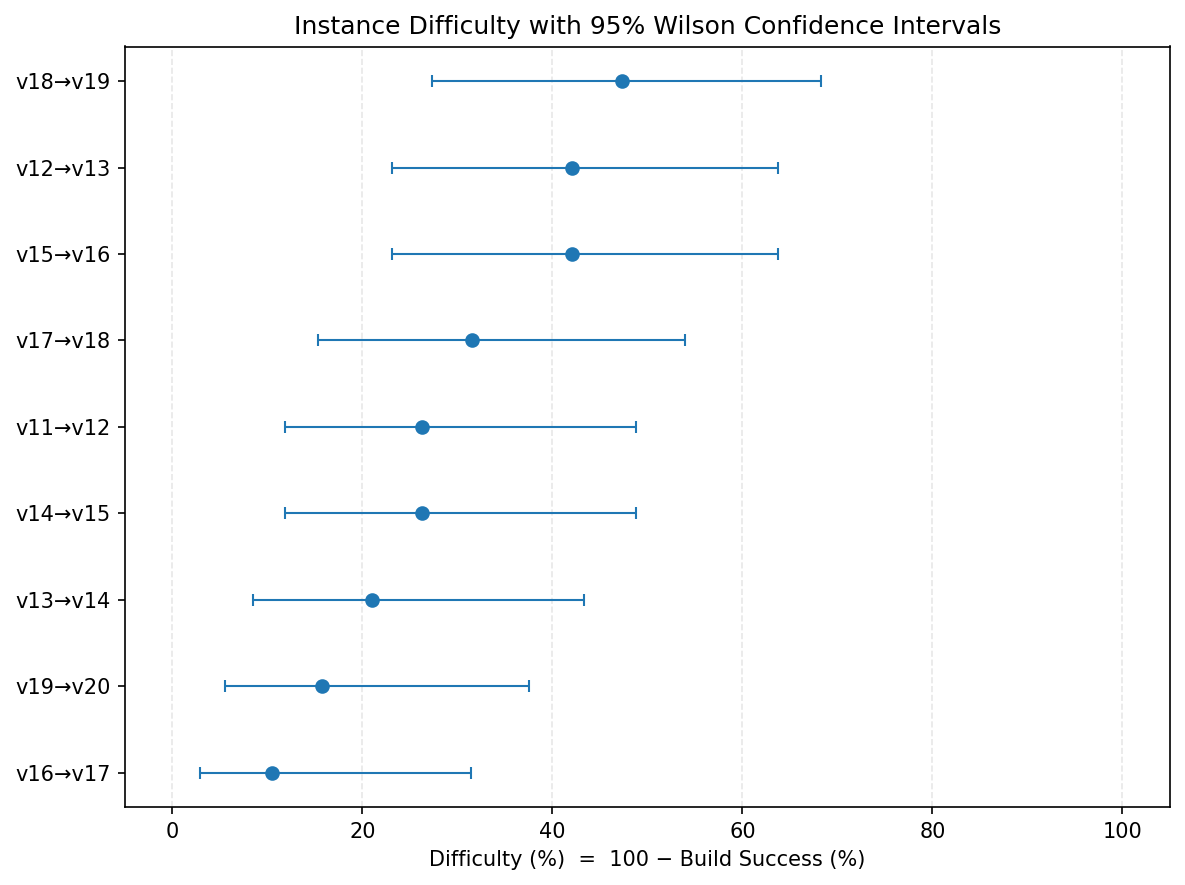


Per-Instance Difficulty Summary (95% Wilson CIs)
- Instances evaluated: 9 | Total runs: 171
- Average difficulty across instances: 29.2% (median 26.3%)
- Range of instance difficulty: 10.5% to 47.4%

Hardest instances:
- v18→v19: difficulty 47.4% (95% CI 27.3%–68.3%), runs n=19, step-limit failures=4, median cost $0.095, median steps 15.0
- v12→v13: difficulty 42.1% (95% CI 23.1%–63.7%), runs n=19, step-limit failures=1, median cost $0.030, median steps 16.0
- v15→v16: difficulty 42.1% (95% CI 23.1%–63.7%), runs n=19, step-limit failures=2, median cost $0.053, median steps 17.0

Easiest instances:
- v16→v17: difficulty 10.5% (95% CI 2.9%–31.4%), runs n=19, step-limit failures=1, median cost $0.020, median steps 16.0
- v19→v20: difficulty 15.8% (95% CI 5.5%–37.6%), runs n=19, step-limit failures=1, median cost $0.019, median steps 16.0
- v13→v14: difficulty 21.1% (95% CI 8.5%–43.3%), runs n=19, step-limit failures=1, median cost $0.024, median steps 12.0

Table (all instances):
instanc

In [34]:
# --- Instance difficulty with 95% Wilson confidence intervals + textual summary ---

import math
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 0) Helpers
def wilson_ci(k: int, n: int, alpha: float = 0.05) -> tuple[float, float]:
    """
    Wilson score interval for a binomial proportion.
    Returns (low, high) for p = k/n at (1 - alpha) confidence.
    """
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # ~ N(0,1).ppf(1 - alpha/2) for alpha=0.05
    p = k / n
    denom = 1 + z**2 / n
    centre = p + z**2 / (2 * n)
    rad = z * math.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)
    low = (centre - rad) / denom
    high = (centre + rad) / denom
    return (max(0.0, low), min(1.0, high))


def short_instance_label(instance_id: str) -> str:
    """
    Compress instance id like '..._v11_to_v12' -> 'v11→v12'.
    Falls back to the tail of the id if pattern not found.
    """
    m = re.search(r"v(\d+)_to_v(\d+)$", instance_id)
    if m:
        return f"v{m.group(1)}→v{m.group(2)}"
    # fallback: last segment after last '__' or whole tail
    tail = instance_id.split("__")[-1]
    return tail[-24:]


# 1) Aggregate per-instance success
inst = df.groupby("instance_id", as_index=False).agg(
    successes=("build_success_effective", "sum"),
    trials=("build_success_effective", "count"),
)

# 2) Compute success rate + Wilson CIs
inst["success_rate"] = inst["successes"] / inst["trials"]
inst[["succ_ci_low", "succ_ci_high"]] = inst.apply(
    lambda r: pd.Series(wilson_ci(int(r["successes"]), int(r["trials"]), alpha=0.05)),
    axis=1,
)

# 3) Convert to difficulty = 1 - success (and transform CIs accordingly)
inst["difficulty"] = 1.0 - inst["success_rate"]
inst["diff_ci_low"] = 1.0 - inst["succ_ci_high"]  # note the flip!
inst["diff_ci_high"] = 1.0 - inst["succ_ci_low"]

# 4) Join a few useful context stats (avg cost, steps, duration)
context = (
    df.assign(duration_minutes=df["experiment_duration_seconds"] / 60)
    .groupby("instance_id", as_index=False)
    .agg(
        avg_cost_usd=("experiment_cost_usd", "mean"),
        median_cost_usd=("experiment_cost_usd", "median"),
        avg_duration_min=("duration_minutes", "mean"),
        median_duration_min=("duration_minutes", "median"),
        avg_step_count=("experiment_step_count", "mean"),
        median_step_count=("experiment_step_count", "median"),
    )
)
inst = inst.merge(context, on="instance_id", how="left")

# 5) Attach step-limit failure counts to help interpret difficulty
step_limit_counts = (
    df[
        (df["experiment_status"] == "failed")
        & (df["failure_category"] == "steps_limit_exceeded")
    ]
    .groupby("instance_id")
    .size()
    .rename("step_limit_failures")
    .reset_index()
)
inst = inst.merge(step_limit_counts, on="instance_id", how="left")
inst["step_limit_failures"] = inst["step_limit_failures"].fillna(0).astype(int)

# 6) Labels and ordering by difficulty (desc)
inst["label"] = inst["instance_id"].map(short_instance_label)
inst = inst.sort_values(["difficulty", "label"], ascending=[False, True]).reset_index(
    drop=True
)

# 7) Plot: horizontal error-bar chart (one figure, defaults only)
y = np.arange(len(inst))
x = inst["difficulty"].to_numpy() * 100.0
xerr_left = (inst["difficulty"] - inst["diff_ci_low"]).to_numpy() * 100.0
xerr_right = (inst["diff_ci_high"] - inst["difficulty"]).to_numpy() * 100.0
xerr = np.vstack([xerr_left, xerr_right])

plt.figure(figsize=(8, 6), dpi=150)
plt.errorbar(x, y, xerr=xerr, fmt="o", capsize=3, elinewidth=1, linewidth=0.8)
plt.yticks(y, inst["label"])
plt.xlabel("Difficulty (%)  =  100 − Build Success (%)")
plt.title("Instance Difficulty with 95% Wilson Confidence Intervals")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.xlim(-5, 105)
plt.gca().invert_yaxis()  # hardest at top
plt.tight_layout()
plt.show()


# 8) Text summary (printed; survives nbconvert to Markdown)
def pct(v):
    return f"{100.0 * float(v):.1f}%"


def line_for(row) -> str:
    return (
        f"- {row['label']}: difficulty {pct(row['difficulty'])} "
        f"(95% CI {pct(row['diff_ci_low'])}–{pct(row['diff_ci_high'])}), "
        f"runs n={int(row['trials'])}, step-limit failures={int(row['step_limit_failures'])}, "
        f"median cost ${float(row['median_cost_usd']):.3f}, median steps {float(row['median_step_count']):.1f}"
    )


avg_diff = float(inst["difficulty"].mean())
med_diff = float(inst["difficulty"].median())
rng = (float(inst["difficulty"].min()), float(inst["difficulty"].max()))

top_k = 3
hardest = inst.head(top_k)
easiest = inst.tail(top_k).sort_values("difficulty", ascending=True)

print("\n" + "=" * 72)
print("Per-Instance Difficulty Summary (95% Wilson CIs)")
print("=" * 72)
print(
    f"- Instances evaluated: {inst.shape[0]} | Total runs: {int(inst['trials'].sum())}"
)
print(
    f"- Average difficulty across instances: {pct(avg_diff)} (median {pct(med_diff)})"
)
print(f"- Range of instance difficulty: {pct(rng[0])} to {pct(rng[1])}")

print("\nHardest instances:")
for _, r in hardest.iterrows():
    print(line_for(r))

print("\nEasiest instances:")
for _, r in easiest.iterrows():
    print(line_for(r))

# Compact table for reference (percentages, rounded)
tbl = inst[
    [
        "label",
        "trials",
        "successes",
        "difficulty",
        "diff_ci_low",
        "diff_ci_high",
        "median_cost_usd",
        "median_step_count",
        "step_limit_failures",
    ]
].copy()
for c in ["difficulty", "diff_ci_low", "diff_ci_high"]:
    tbl[c] = (tbl[c] * 100).round(1)
tbl["median_cost_usd"] = tbl["median_cost_usd"].round(3)
tbl["median_step_count"] = tbl["median_step_count"].round(1)

print("\nTable (all instances):")
print(
    tbl.rename(
        columns={
            "label": "instance",
            "trials": "runs",
            "successes": "build_passes",
            "difficulty": "difficulty_%",
            "diff_ci_low": "ci_low_%",
            "diff_ci_high": "ci_high_%",
        }
    ).to_string(index=False)
)


## Cost vs Success Visualization

To balance accuracy against spend, we chart each agent's pipeline success rate
against its average experiment cost. This scatter plot makes it easy to spot
frontier models (high success, low cost) versus those that are both pricey and
unreliable.



Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


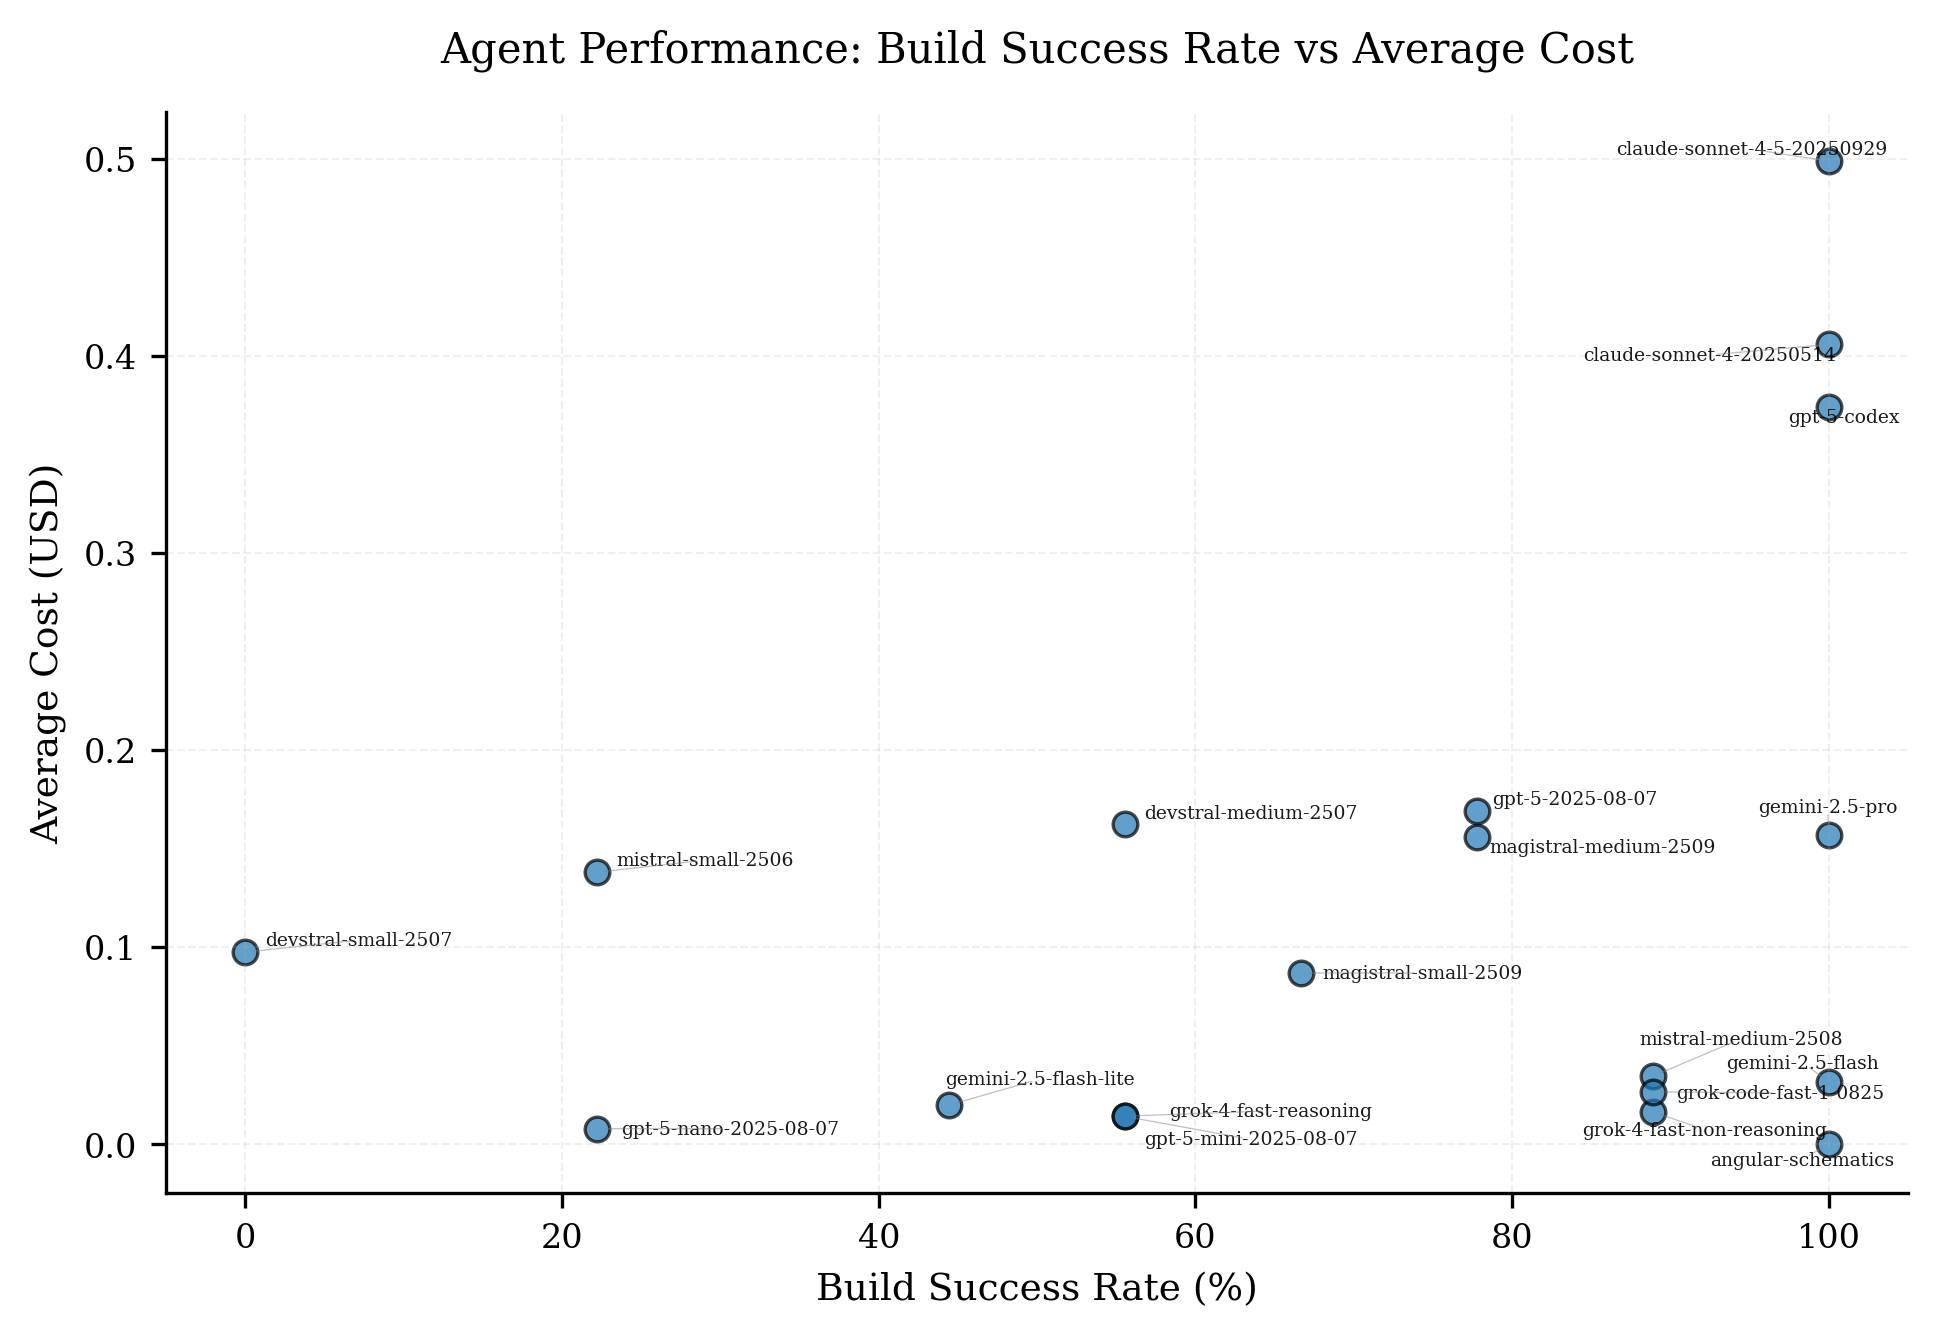


Agent Performance Summary:
                  agent_display_name  build_success_rate  avg_cost  n_experiments
         angular-schematics/789e301f            1.000000  0.000000              9
  anthropic/claude-sonnet-4-20250514            1.000000  0.405640              9
anthropic/claude-sonnet-4-5-20250929            1.000000  0.498659              9
             gemini/gemini-2.5-flash            1.000000  0.031685              9
               gemini/gemini-2.5-pro            1.000000  0.156724              9
                  openai/gpt-5-codex            1.000000  0.373889              9
       xai/grok-4-fast-non-reasoning            0.888889  0.016287              9
         mistral/mistral-medium-2508            0.888889  0.034454              9
           xai/grok-code-fast-1-0825            0.888889  0.026455              9
       mistral/magistral-medium-2509            0.777778  0.155920              9
             openai/gpt-5-2025-08-07            0.777778  0.169046    

In [35]:
import matplotlib.pyplot as plt

# Calculate metrics per agent
agent_metrics = (
    df.groupby("agent_display_name")
    .agg(
        build_success_rate=("build_success_effective", lambda x: x.sum() / len(x)),
        avg_cost=("experiment_cost_usd", "mean"),
        n_experiments=("experiment_id", "count"),
    )
    .reset_index()
)

# Set publication-quality style
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8

# Create scatter plot with full-width thesis size (A4 page width minus margins)
fig, ax = plt.subplots(figsize=(6.5, 4.5), dpi=300)

scatter = ax.scatter(
    agent_metrics["build_success_rate"] * 100,
    agent_metrics["avg_cost"],
    s=35,  # Reduced marker size for better proportions
    alpha=0.7,
    color="tab:blue",  # Use a single color for all points
    edgecolors="black",
    linewidth=0.8,
)


def _format_label(agent_display_name: str):
    if "schematics" in agent_display_name:
        return "angular-schematics"
    return agent_display_name.split("/")[-1]


from adjustText import adjust_text

texts = []
for _idx, row in agent_metrics.iterrows():
    agent_name = _format_label(str(row["agent_display_name"]))  # Show only model name
    success_pct = float(row["build_success_rate"]) * 100
    cost = float(row["avg_cost"])
    text = ax.text(success_pct, cost, agent_name, fontsize=4.5, alpha=0.9)
    texts.append(text)

# Adjust text positions to avoid overlap with more aggressive parameters
adjust_text(
    texts,
    arrowprops={"arrowstyle": "-", "color": "gray", "lw": 0.3, "alpha": 0.5},
    expand_points=(2.2, 2.5),
    force_text=(1.2, 1.5),
    force_points=(0.6, 0.8),
    lim=5000,
    avoid_self=True,
    only_move={"text": "xy", "points": "xy", "objects": "xy"},
)

# Styling
ax.set_xlabel("Build Success Rate (%)", fontsize=9)
ax.set_ylabel("Average Cost (USD)", fontsize=9)
ax.set_title(
    "Agent Performance: Build Success Rate vs Average Cost", fontsize=10, pad=12
)
ax.tick_params(axis="both", which="major", labelsize=8)
ax.grid(True, alpha=0.2, linestyle="--", linewidth=0.5)
ax.set_xlim(-5, 105)

# Add quadrant lines
median_success = float(agent_metrics["build_success_rate"].median()) * 100
median_cost = float(agent_metrics["avg_cost"].median())
# ax.axhline(y=median_cost, color="gray", linestyle=":", alpha=0.4, linewidth=1)
# ax.axvline(x=median_success, color="gray", linestyle=":", alpha=0.4, linewidth=1)

# Cleaner spines for publication
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nAgent Performance Summary:")
print(
    agent_metrics.sort_values("build_success_rate", ascending=False).to_string(
        index=False
    )
)
print(f"\nMedian Build Success Rate: {median_success:.1f}%")
print(f"Median Average Cost: ${median_cost:.4f}")


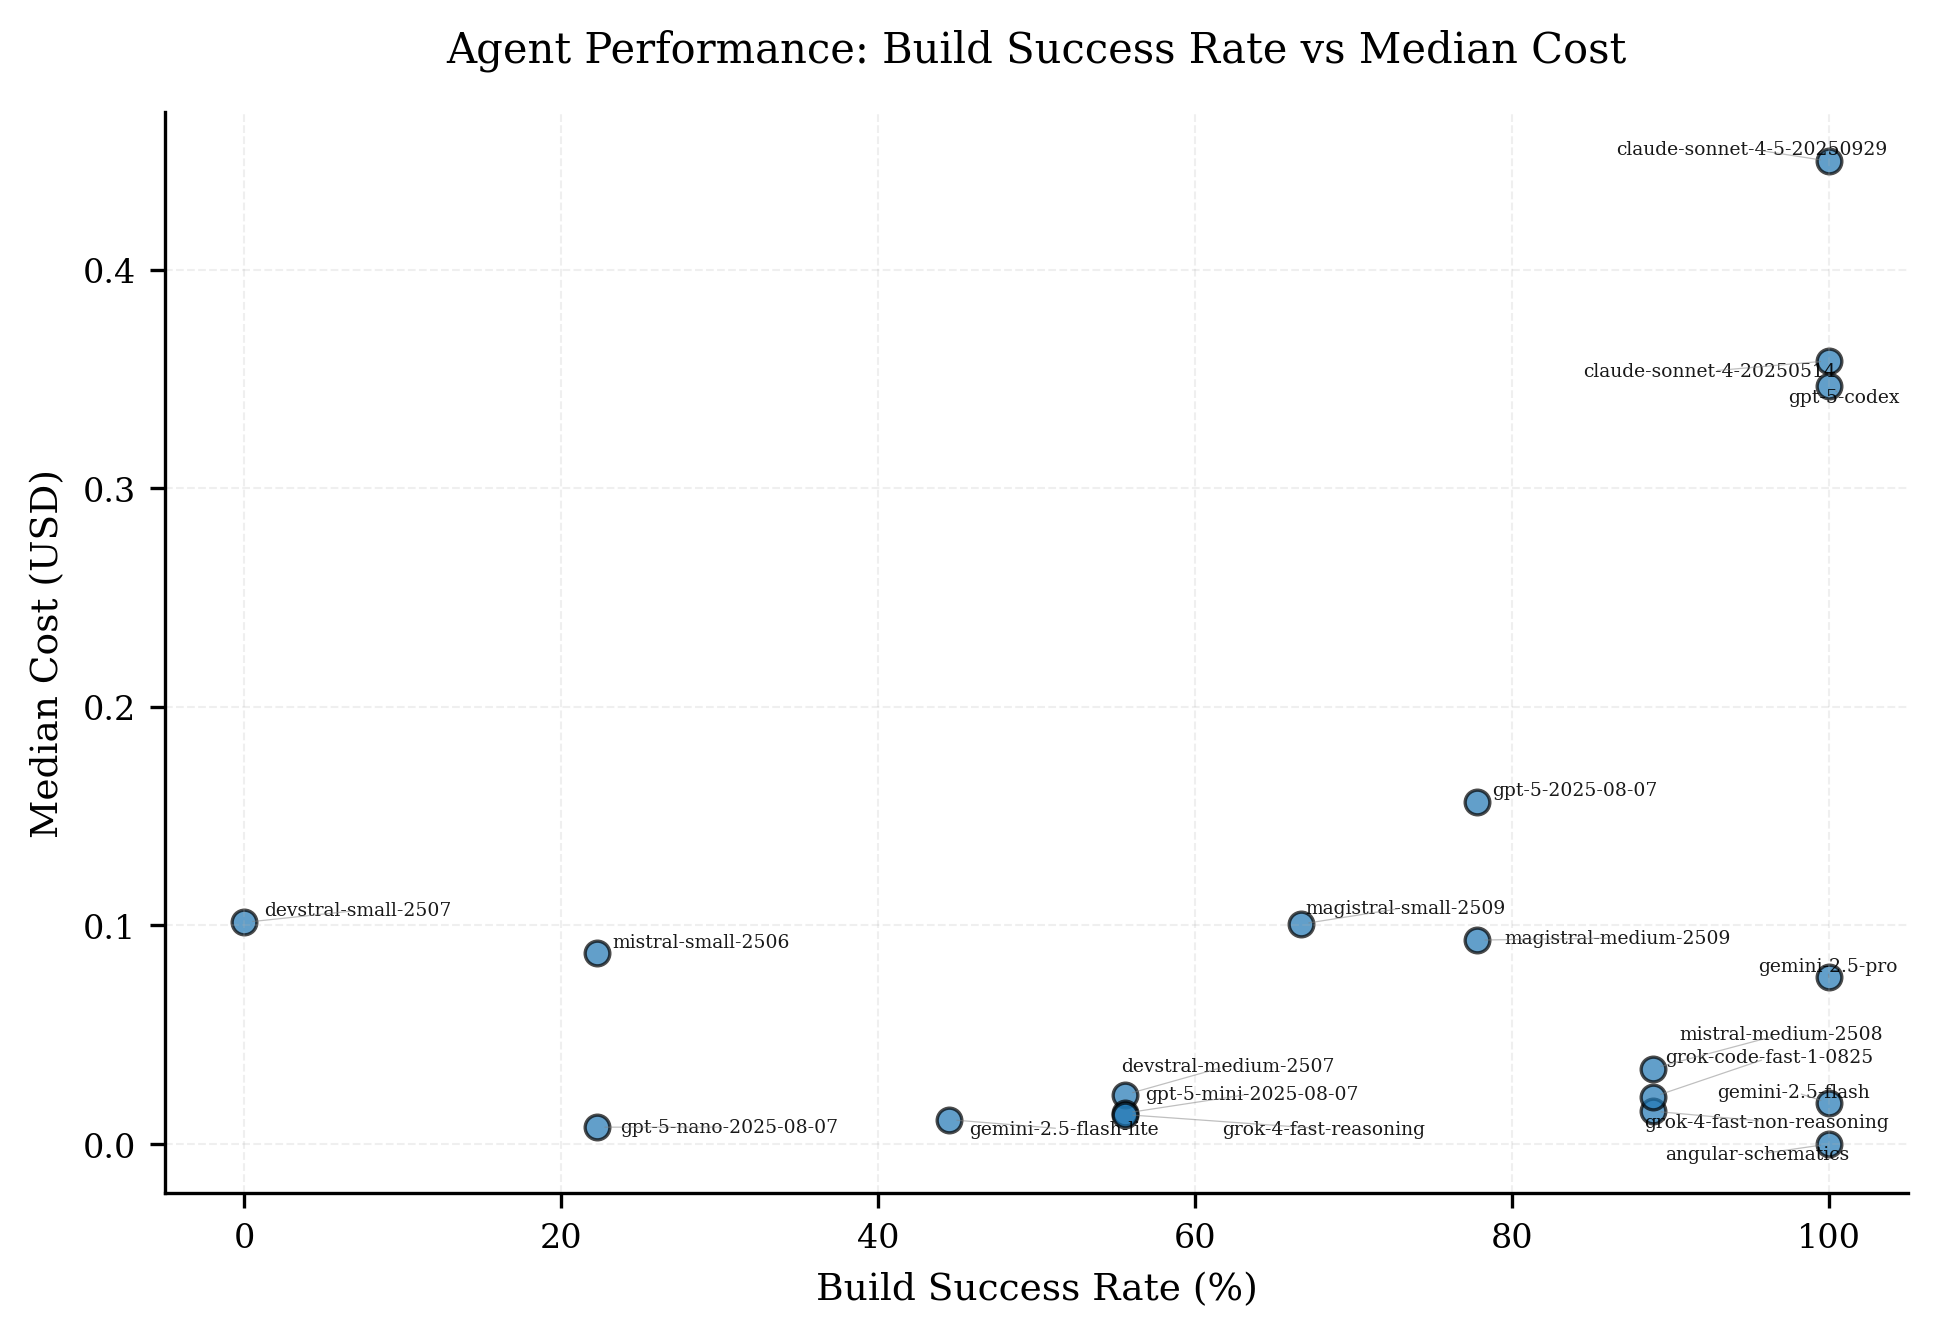


Agent Performance Summary:
                  agent_display_name  build_success_rate  median_cost  n_experiments
         angular-schematics/789e301f            1.000000     0.000000              9
  anthropic/claude-sonnet-4-20250514            1.000000     0.358329              9
anthropic/claude-sonnet-4-5-20250929            1.000000     0.449664              9
             gemini/gemini-2.5-flash            1.000000     0.018771              9
               gemini/gemini-2.5-pro            1.000000     0.076272              9
                  openai/gpt-5-codex            1.000000     0.346712              9
       xai/grok-4-fast-non-reasoning            0.888889     0.015045              9
         mistral/mistral-medium-2508            0.888889     0.034542              9
           xai/grok-code-fast-1-0825            0.888889     0.021504              9
       mistral/magistral-medium-2509            0.777778     0.093286              9
             openai/gpt-5-2025-08-07 

In [36]:
import matplotlib.pyplot as plt

# Calculate metrics per agent using median cost
agent_metrics = (
    df.groupby("agent_display_name")
    .agg(
        build_success_rate=("build_success_effective", lambda x: x.sum() / len(x)),
        median_cost=("experiment_cost_usd", "median"),
        n_experiments=("experiment_id", "count"),
    )
    .reset_index()
)

# Set publication-quality style
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8

# Create scatter plot with full-width thesis size (A4 page width minus margins)
fig, ax = plt.subplots(figsize=(6.5, 4.5), dpi=300)

scatter = ax.scatter(
    agent_metrics["build_success_rate"] * 100,
    agent_metrics["median_cost"],
    s=35,  # Reduced marker size for better proportions
    alpha=0.7,
    color="tab:blue",  # Use a single color for all points
    edgecolors="black",
    linewidth=0.8,
)


def _format_label(agent_display_name: str):
    if "schematics" in agent_display_name:
        return "angular-schematics"
    return agent_display_name.split("/")[-1]


from adjustText import adjust_text

texts = []
for _idx, row in agent_metrics.iterrows():
    agent_name = _format_label(str(row["agent_display_name"]))  # Show only model name
    success_pct = float(row["build_success_rate"]) * 100
    cost = float(row["median_cost"])
    text = ax.text(success_pct, cost, agent_name, fontsize=4.5, alpha=0.9)
    texts.append(text)

# Adjust text positions to avoid overlap with more aggressive parameters
adjust_text(
    texts,
    arrowprops={"arrowstyle": "-", "color": "gray", "lw": 0.3, "alpha": 0.5},
    expand_points=(2.2, 2.5),
    force_text=(1.2, 1.5),
    force_points=(0.6, 0.8),
    lim=5000,
    avoid_self=True,
    only_move={"text": "xy", "points": "xy", "objects": "xy"},
)

# Styling
ax.set_xlabel("Build Success Rate (%)", fontsize=9)
ax.set_ylabel("Median Cost (USD)", fontsize=9)
ax.set_title(
    "Agent Performance: Build Success Rate vs Median Cost", fontsize=10, pad=12
)
ax.tick_params(axis="both", which="major", labelsize=8)
ax.grid(True, alpha=0.2, linestyle="--", linewidth=0.5)
ax.set_xlim(-5, 105)

# Add quadrant lines
median_success = float(agent_metrics["build_success_rate"].median()) * 100
median_cost = float(agent_metrics["median_cost"].median())
# ax.axhline(y=median_cost, color="gray", linestyle=":", alpha=0.4, linewidth=1)
# ax.axvline(x=median_success, color="gray", linestyle=":", alpha=0.4, linewidth=1)

# Cleaner spines for publication
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nAgent Performance Summary:")
print(
    agent_metrics.sort_values("build_success_rate", ascending=False).to_string(
        index=False
    )
)
print(f"\nMedian Build Success Rate: {median_success:.1f}%")
print(f"Median Median Cost: ${median_cost:.4f}")




Agents in the upper-left quadrant are promising optimization targets, while
those in the lower-right likely need pruning or new prompting strategies.

The additional *_effective columns expose the sequential pipeline checks while
keeping the original tri-state signals for forensic work. In the rest of the notebook, we should use these metrics for comparing agents (e.g in Leaderboard)


,agent,build_passes,total_runs,success_%,ci_low_%,ci_high_%
0,angular-schematics/789e301f,9,9,100.0,70.1,100.0
1,anthropic/claude-sonnet-4-20250514,9,9,100.0,70.1,100.0
2,anthropic/claude-sonnet-4-5-20250929,9,9,100.0,70.1,100.0
3,gemini/gemini-2.5-flash,9,9,100.0,70.1,100.0
4,gemini/gemini-2.5-pro,9,9,100.0,70.1,100.0
5,openai/gpt-5-codex,9,9,100.0,70.1,100.0
6,xai/grok-4-fast-non-reasoning,8,9,88.9,56.5,98.0
7,xai/grok-code-fast-1-0825,8,9,88.9,56.5,98.0
8,mistral/mistral-medium-2508,8,9,88.9,56.5,98.0
9,openai/gpt-5-2025-08-07,7,9,77.8,45.3,93.7


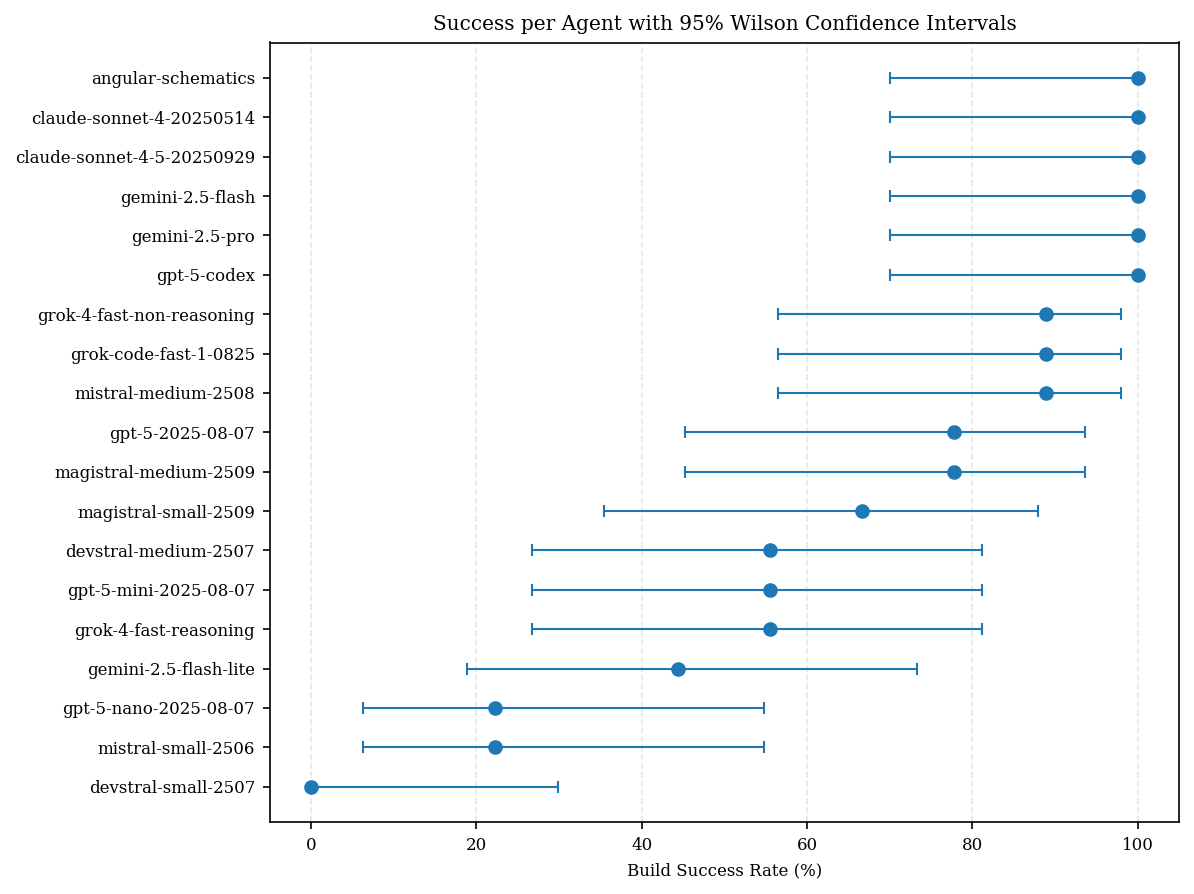

In [37]:
# --- Success per agent with 95% Wilson confidence intervals ---

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def wilson_ci(k: int, n: int, alpha: float = 0.05) -> tuple[float, float]:
    """
    Wilson score interval for a binomial proportion.
    Returns (low, high) for p = k/n at (1 - alpha) confidence.
    """
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # ~ N(0,1).ppf(1 - alpha/2) for alpha=0.05
    p = k / n
    denom = 1 + z**2 / n
    centre = p + z**2 / (2 * n)
    rad = z * math.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)
    low = (centre - rad) / denom
    high = (centre + rad) / denom
    return (max(0.0, low), min(1.0, high))


# 1) Aggregate successes by agent
agent_outcomes = df.groupby("agent_display_name", as_index=False).agg(
    successes=("build_success_effective", "sum"),
    trials=("build_success_effective", "count"),
)

# 2) Compute rates + CIs
ci_low = []
ci_high = []
rate = []
for _, row in agent_outcomes.iterrows():
    k, n = int(row["successes"]), int(row["trials"])
    r = k / n if n else np.nan
    low, high = wilson_ci(k, n, alpha=0.05)
    rate.append(r)
    ci_low.append(low)
    ci_high.append(high)

agent_outcomes["success_rate"] = rate
agent_outcomes["ci_low"] = ci_low
agent_outcomes["ci_high"] = ci_high


# 3) (Optional) tidy label for plotting
def short_label(name: str) -> str:
    if "schematics" in name:
        return "angular-schematics"
    # show just the model name (text after the last "/")
    return name.split("/")[-1]


agent_outcomes["label"] = agent_outcomes["agent_display_name"].map(short_label)

# 4) Order by success rate desc, then by label asc for stability
agent_outcomes = agent_outcomes.sort_values(
    by=["success_rate", "label"], ascending=[False, True]
).reset_index(drop=True)

# 5) Nice summary table
summary_cols = [
    "agent_display_name",
    "successes",
    "trials",
    "success_rate",
    "ci_low",
    "ci_high",
]
summary = agent_outcomes[summary_cols].copy()
summary["success_rate"] = (summary["success_rate"] * 100).round(1)
summary["ci_low"] = (summary["ci_low"] * 100).round(1)
summary["ci_high"] = (summary["ci_high"] * 100).round(1)
summary.rename(
    columns={
        "agent_display_name": "agent",
        "successes": "build_passes",
        "trials": "total_runs",
        "success_rate": "success_%",
        "ci_low": "ci_low_%",
        "ci_high": "ci_high_%",
    },
    inplace=True,
)

display(summary)

# 6) Plot: horizontal errorbar chart (one figure, default colors)
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

y = np.arange(len(agent_outcomes))
x = agent_outcomes["success_rate"].to_numpy() * 100.0
xerr_left = (
    agent_outcomes["success_rate"] - agent_outcomes["ci_low"]
).to_numpy() * 100.0
xerr_right = (
    agent_outcomes["ci_high"] - agent_outcomes["success_rate"]
).to_numpy() * 100.0
xerr = np.vstack([xerr_left, xerr_right])

ax.errorbar(
    x,
    y,
    xerr=xerr,
    fmt="o",
    capsize=3,
    elinewidth=1,
    linewidth=0.8,
)

ax.set_yticks(y)
ax.set_yticklabels(agent_outcomes["label"])
ax.set_xlabel("Build Success Rate (%)")
ax.set_title("Success per Agent with 95% Wilson Confidence Intervals")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)
ax.set_xlim(-5, 105)

# Invert y-axis so the best agents (top rates) appear at the top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


,agent,build_passes,total_runs,success_%,ci_low_%,ci_high_%
0,angular-schematics/789e301f,9,9,100.0,70.1,100.0
1,anthropic/claude-sonnet-4-20250514,9,9,100.0,70.1,100.0
2,anthropic/claude-sonnet-4-5-20250929,9,9,100.0,70.1,100.0
3,gemini/gemini-2.5-flash,9,9,100.0,70.1,100.0
4,gemini/gemini-2.5-pro,9,9,100.0,70.1,100.0
5,openai/gpt-5-codex,9,9,100.0,70.1,100.0
6,xai/grok-4-fast-non-reasoning,8,9,88.9,56.5,98.0
7,xai/grok-code-fast-1-0825,8,9,88.9,56.5,98.0
8,mistral/mistral-medium-2508,8,9,88.9,56.5,98.0
9,openai/gpt-5-2025-08-07,7,9,77.8,45.3,93.7


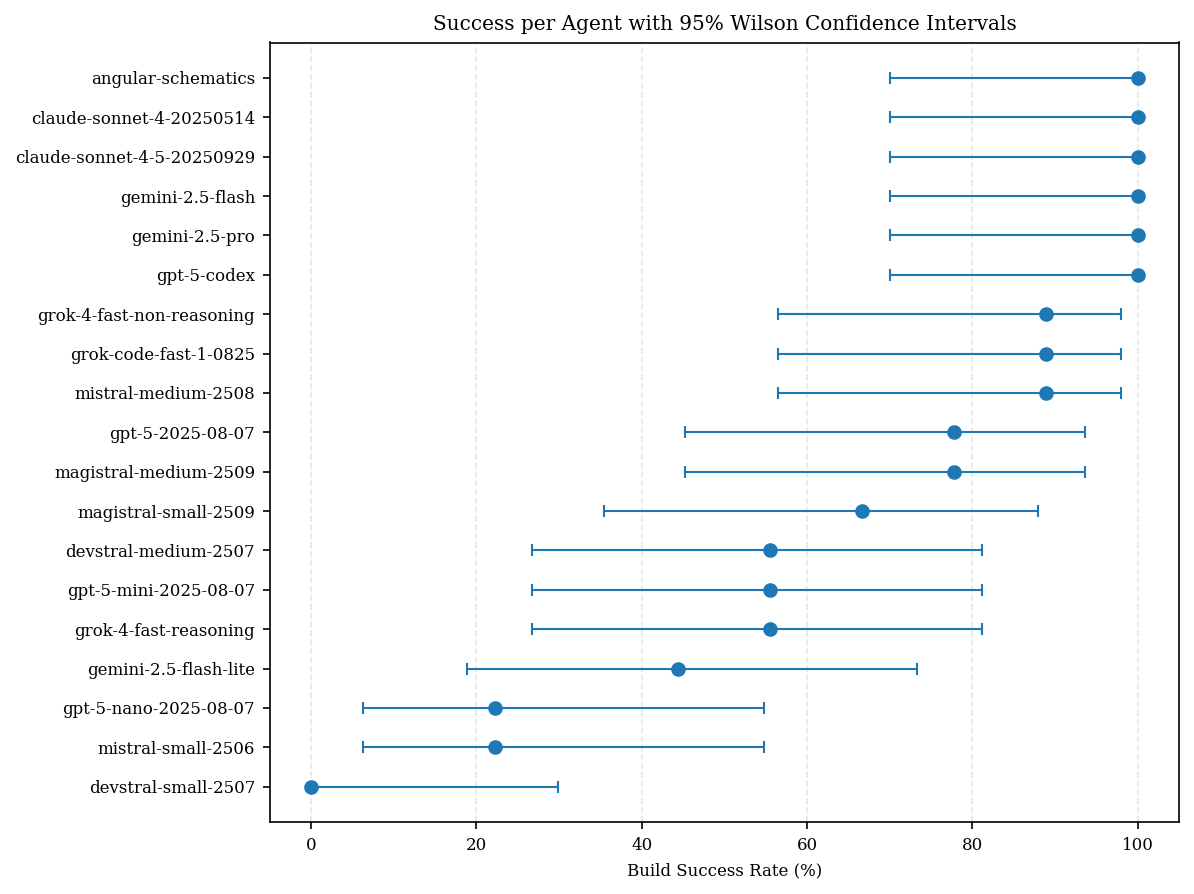

In [38]:
# --- Success per agent with 95% Wilson confidence intervals ---

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def wilson_ci(k: int, n: int, alpha: float = 0.05) -> tuple[float, float]:
    """
    Wilson score interval for a binomial proportion.
    Returns (low, high) for p = k/n at (1 - alpha) confidence.
    """
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # ~ N(0,1).ppf(1 - alpha/2) for alpha=0.05
    p = k / n
    denom = 1 + z**2 / n
    centre = p + z**2 / (2 * n)
    rad = z * math.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)
    low = (centre - rad) / denom
    high = (centre + rad) / denom
    return (max(0.0, low), min(1.0, high))


# 1) Aggregate successes by agent
agent_outcomes = df.groupby("agent_display_name", as_index=False).agg(
    successes=("build_success_effective", "sum"),
    trials=("build_success_effective", "count"),
)

# 2) Compute rates + CIs
ci_low = []
ci_high = []
rate = []
for _, row in agent_outcomes.iterrows():
    k, n = int(row["successes"]), int(row["trials"])
    r = k / n if n else np.nan
    low, high = wilson_ci(k, n, alpha=0.05)
    rate.append(r)
    ci_low.append(low)
    ci_high.append(high)

agent_outcomes["success_rate"] = rate
agent_outcomes["ci_low"] = ci_low
agent_outcomes["ci_high"] = ci_high


# 3) (Optional) tidy label for plotting
def short_label(name: str) -> str:
    if "schematics" in name:
        return "angular-schematics"
    # show just the model name (text after the last "/")
    return name.split("/")[-1]


agent_outcomes["label"] = agent_outcomes["agent_display_name"].map(short_label)

# 4) Order by success rate desc, then by label asc for stability
agent_outcomes = agent_outcomes.sort_values(
    by=["success_rate", "label"], ascending=[False, True]
).reset_index(drop=True)

# 5) Nice summary table
summary_cols = [
    "agent_display_name",
    "successes",
    "trials",
    "success_rate",
    "ci_low",
    "ci_high",
]
summary = agent_outcomes[summary_cols].copy()
summary["success_rate"] = (summary["success_rate"] * 100).round(1)
summary["ci_low"] = (summary["ci_low"] * 100).round(1)
summary["ci_high"] = (summary["ci_high"] * 100).round(1)
summary.rename(
    columns={
        "agent_display_name": "agent",
        "successes": "build_passes",
        "trials": "total_runs",
        "success_rate": "success_%",
        "ci_low": "ci_low_%",
        "ci_high": "ci_high_%",
    },
    inplace=True,
)


display(summary)

# Export the summary table to CSV
summary.to_csv("build_success_summary.csv", index=False)


# 6) Plot: horizontal errorbar chart (one figure, default colors)
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

y = np.arange(len(agent_outcomes))
x = agent_outcomes["success_rate"].to_numpy() * 100.0
xerr_left = (
    agent_outcomes["success_rate"] - agent_outcomes["ci_low"]
).to_numpy() * 100.0
xerr_right = (
    agent_outcomes["ci_high"] - agent_outcomes["success_rate"]
).to_numpy() * 100.0
xerr = np.vstack([xerr_left, xerr_right])

ax.errorbar(
    x,
    y,
    xerr=xerr,
    fmt="o",
    capsize=3,
    elinewidth=1,
    linewidth=0.8,
)

ax.set_yticks(y)
ax.set_yticklabels(agent_outcomes["label"])
ax.set_xlabel("Build Success Rate (%)")
ax.set_title("Success per Agent with 95% Wilson Confidence Intervals")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)
ax.set_xlim(-5, 105)

# Invert y-axis so the best agents (top rates) appear at the top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


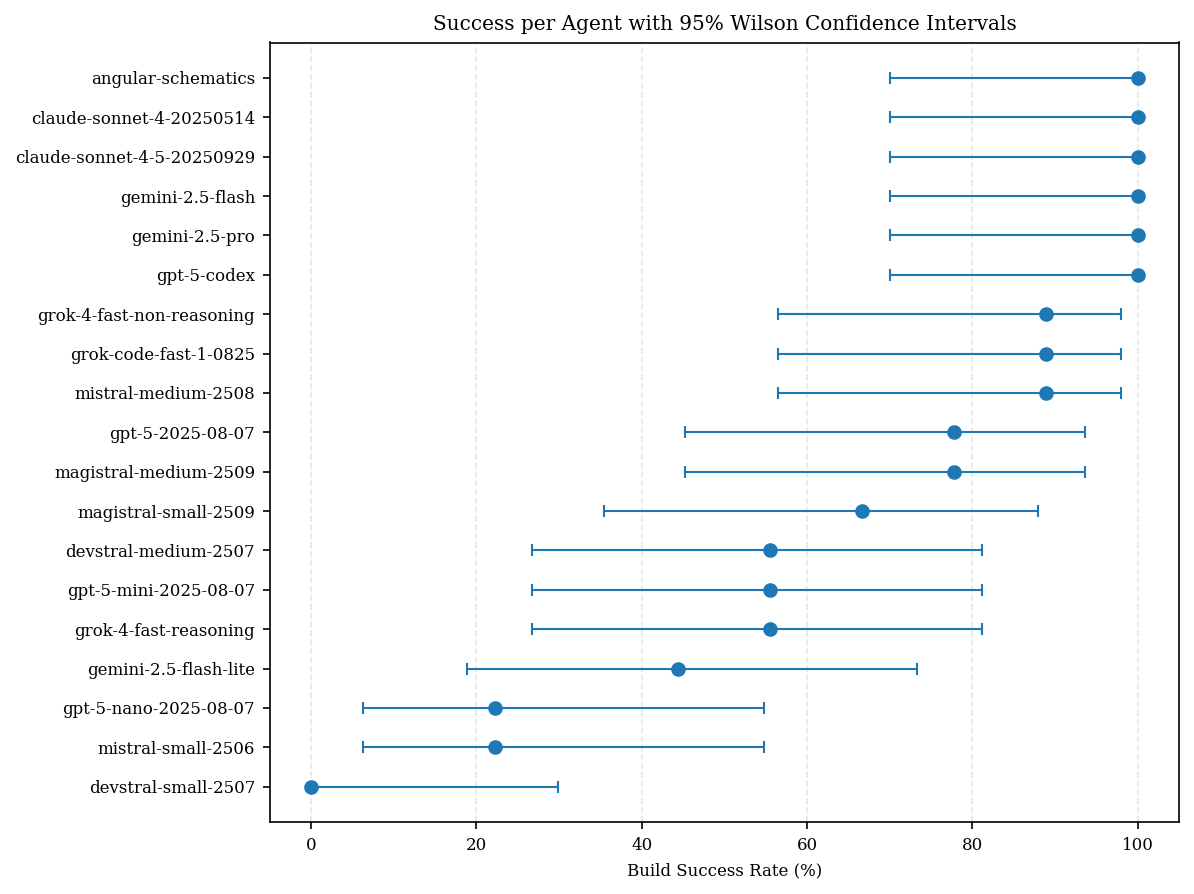


Summary: Agent Success with 95% Confidence Intervals
- Agents evaluated: 19  |  Total runs: 171
- Median agent success rate: 77.8%

Top performers (by success rate):
- angular-schematics: 100.0% (95% CI 70.1–100.0%), median cost $0.000 (n=9)
- claude-sonnet-4-20250514: 100.0% (95% CI 70.1–100.0%), median cost $0.358 (n=9)
- claude-sonnet-4-5-20250929: 100.0% (95% CI 70.1–100.0%), median cost $0.450 (n=9)
- gemini-2.5-flash: 100.0% (95% CI 70.1–100.0%), median cost $0.019 (n=9)
- gemini-2.5-pro: 100.0% (95% CI 70.1–100.0%), median cost $0.076 (n=9)

Cost-efficient above-median performers (sorted by median cost):
- angular-schematics: 100.0% (95% CI 70.1–100.0%), median cost $0.000 (n=9)
- grok-4-fast-non-reasoning: 88.9% (95% CI 56.5–98.0%), median cost $0.015 (n=9)
- gemini-2.5-flash: 100.0% (95% CI 70.1–100.0%), median cost $0.019 (n=9)
- grok-code-fast-1-0825: 88.9% (95% CI 56.5–98.0%), median cost $0.022 (n=9)
- mistral-medium-2508: 88.9% (95% CI 56.5–98.0%), median cost $0.035 (n=

In [ ]:
# --- Success per agent with 95% Wilson confidence intervals + textual summary ---

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 0) Helpers
def wilson_ci(k: int, n: int, alpha: float = 0.05) -> tuple[float, float]:
    """
    Wilson score interval for a binomial proportion.
    Returns (low, high) for p = k/n at (1 - alpha) confidence.
    """
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # ~ N(0,1).ppf(1 - alpha/2) for alpha=0.05
    p = k / n
    denom = 1 + z**2 / n
    centre = p + z**2 / (2 * n)
    rad = z * math.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)
    low = (centre - rad) / denom
    high = (centre + rad) / denom
    return (max(0.0, low), min(1.0, high))


def short_label(name: str) -> str:
    if "schematics" in name:
        return "angular-schematics"
    return name.split("/")[-1]


# 1) Aggregate successes by agent
agent_outcomes = df.groupby("agent_display_name", as_index=False).agg(
    successes=("build_success_effective", "sum"),
    trials=("build_success_effective", "count"),
)

# 2) Compute rates + 95% Wilson CIs
agent_outcomes["success_rate"] = agent_outcomes["successes"] / agent_outcomes["trials"]
agent_outcomes[["ci_low", "ci_high"]] = agent_outcomes.apply(
    lambda r: pd.Series(wilson_ci(int(r["successes"]), int(r["trials"]), alpha=0.05)),
    axis=1,
)

# 3) Attach median cost for context
agent_cost = df.groupby("agent_display_name", as_index=False).agg(
    median_cost_usd=("experiment_cost_usd", "median")
)
agent_outcomes = agent_outcomes.merge(agent_cost, on="agent_display_name", how="left")
agent_outcomes["label"] = agent_outcomes["agent_display_name"].map(short_label)

# 4) Sort by success (desc), then label for stability
agent_outcomes = agent_outcomes.sort_values(
    by=["success_rate", "label"], ascending=[False, True]
).reset_index(drop=True)

# 5) Human-friendly summary table
summary = agent_outcomes[
    [
        "agent_display_name",
        "successes",
        "trials",
        "success_rate",
        "ci_low",
        "ci_high",
        "median_cost_usd",
    ]
].copy()
summary["success_rate"] = (summary["success_rate"] * 100).round(1)
summary["ci_low"] = (summary["ci_low"] * 100).round(1)
summary["ci_high"] = (summary["ci_high"] * 100).round(1)
summary["median_cost_usd"] = summary["median_cost_usd"].round(3)
summary = summary.rename(
    columns={
        "agent_display_name": "agent",
        "successes": "build_passes",
        "trials": "total_runs",
        "success_rate": "success_%",
        "ci_low": "ci_low_%",
        "ci_high": "ci_high_%",
    }
)

# 6) Plot (single chart, Matplotlib defaults, no explicit colors)
y = np.arange(len(agent_outcomes))
x = agent_outcomes["success_rate"].to_numpy() * 100.0
xerr_left = (
    agent_outcomes["success_rate"] - agent_outcomes["ci_low"]
).to_numpy() * 100.0
xerr_right = (
    agent_outcomes["ci_high"] - agent_outcomes["success_rate"]
).to_numpy() * 100.0
xerr = np.vstack([xerr_left, xerr_right])

plt.figure(figsize=(8, 6), dpi=150)
plt.errorbar(x, y, xerr=xerr, fmt="o", capsize=3, elinewidth=1, linewidth=0.8)
plt.yticks(y, agent_outcomes["label"])
plt.xlabel("Build Success Rate (%)")
plt.title("Success per Agent with 95% Wilson Confidence Intervals")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.xlim(-5, 105)
plt.gca().invert_yaxis()  # best at top
plt.tight_layout()
plt.show()

# 7) Text summary (printed so it survives nbconvert to Markdown)
n_agents = int(agent_outcomes.shape[0])
total_runs = int(agent_outcomes["trials"].sum())
median_success = float(agent_outcomes["success_rate"].median()) * 100.0

top_k = 5
top_agents = agent_outcomes.head(top_k).copy()
cost_eff = (
    agent_outcomes[agent_outcomes["success_rate"] * 100.0 >= median_success]
    .sort_values(by=["median_cost_usd", "success_rate"], ascending=[True, False])
    .head(5)
    .copy()
)
needs_attention = (
    agent_outcomes[agent_outcomes["success_rate"] < 0.5]
    .sort_values(by=["success_rate", "median_cost_usd"], ascending=[True, True])
    .head(5)
    .copy()
)


def line_for(row) -> str:
    return (
        f"- {row['label']}: {row['success_rate'] * 100:.1f}% "
        f"(95% CI {row['ci_low'] * 100:.1f}-{row['ci_high'] * 100:.1f}%), "
        f"median cost ${row['median_cost_usd']:.3f} (n={int(row['trials'])})"
    )


print("\n" + "=" * 72)
print("Summary: Agent Success with 95% Confidence Intervals")
print("=" * 72)
print(f"- Agents evaluated: {n_agents}  |  Total runs: {total_runs}")
print(f"- Median agent success rate: {median_success:.1f}%")
print("\nTop performers (by success rate):")
for _, r in top_agents.iterrows():
    print(line_for(r))

if not cost_eff.empty:
    print("\nCost-efficient above-median performers (sorted by median cost):")
    for _, r in cost_eff.iterrows():
        print(line_for(r))

if not needs_attention.empty:
    print("\nAgents likely needing attention (success < 50%):")
    for _, r in needs_attention.iterrows():
        print(line_for(r))

print("\nTable (all agents):")
print(summary.to_string(index=False))


### Steps analysis

In [40]:
from bench_mac.core.models import CommandResult

assert all(e.artifacts and e.artifacts.execution_trace for e in experiments), (
    "All experiments should have an execution trace for the section of the notebook"
)


def _get_steps_or_crash(
    e: CompletedExperiment | FailedExperiment,
) -> list[CommandResult]:
    artifacts = e.artifacts
    if not artifacts:
        raise ValueError("No artifacts found for experiment")
    execution_trace = artifacts.execution_trace
    if not execution_trace:
        raise ValueError("No execution trace found for experiment")
    return execution_trace.steps


exp = experiments[0]
steps = _get_steps_or_crash(exp)
(
    steps[0].command,
    steps[0].stdout[:300],
    steps[0].stderr[:300],
    steps[0].exit_code,
    steps[0].duration,
)

('npm ci --legacy-peer-deps',
 '\nadded 1512 packages in 29s\n',
 "npm WARN EBADENGINE Unsupported engine {\nnpm WARN EBADENGINE   package: 'ang2-conduit@0.0.0',\nnpm WARN EBADENGINE   required: { node: '^10.13.0 || ^12.11.1' },\nnpm WARN EBADENGINE   current: { node: 'v16.20.2', npm: '8.19.4' }\nnpm WARN EBADENGINE }\nnpm WARN EBADENGINE Unsupported engine {\nnpm WARN E",
 0,
 datetime.timedelta(seconds=29, microseconds=581430))

In [41]:
df.columns


Index(['instance_id', 'agent_key', 'agent_display_name', 'agent_scaffold',
       'experiment_status', 'failure_category', 'submission_id', 'empty_diff',
       'evaluation_status', 'evaluation_id', 'patch_application_success',
       'install_success', 'target_version_achieved', 'build_success',
       'install_success_effective', 'target_version_achieved_effective',
       'build_success_effective', 'experiment_id', 'experiment_started_at',
       'experiment_ended_at', 'experiment_duration_seconds',
       'experiment_cost_usd', 'experiment_n_calls', 'experiment_step_count'],
      dtype='object')

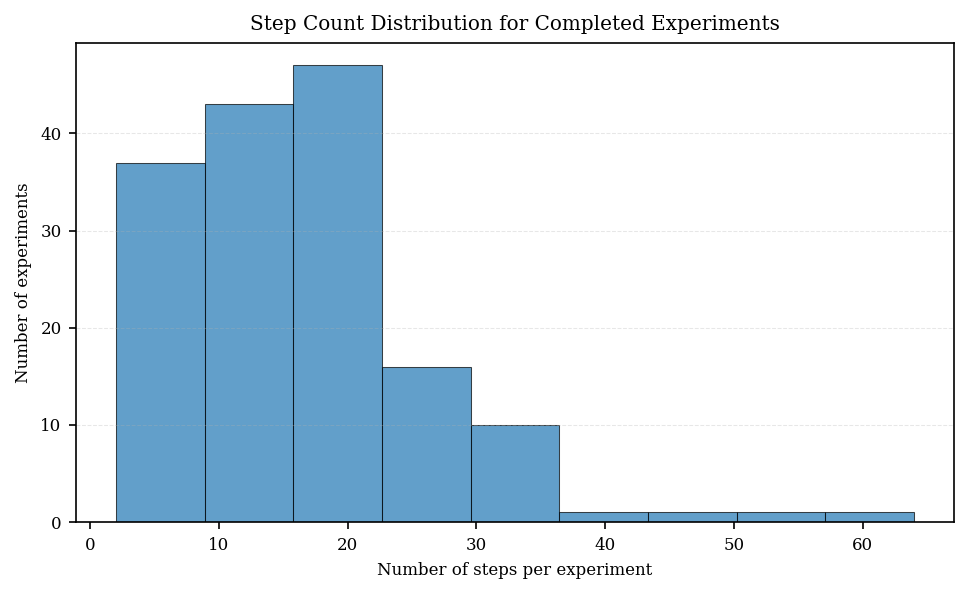

count    157.000000
mean      15.904459
std        9.887044
min        2.000000
25%        9.000000
50%       15.000000
75%       20.000000
80%       22.000000
95%       31.200000
99%       50.280000
max       64.000000


In [42]:
import matplotlib.pyplot as plt

# Only keep experiments where experiment_status == "completed"
completed_df = df[df["experiment_status"] == "completed"]
series = completed_df["experiment_step_count"]
if hasattr(series, "dropna"):
    series = series.dropna()

# Use Sturges' rule to determine the number of bins
n = len(series)
bins = math.ceil(math.log2(n) + 1) if n > 0 else 1

plt.figure(figsize=(6.5, 4), dpi=150)
plt.hist(
    series,
    bins=bins,
    color="tab:blue",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)
plt.xlabel("Number of steps per experiment")
plt.ylabel("Number of experiments")
plt.title("Step Count Distribution for Completed Experiments")
plt.grid(True, axis="y", alpha=0.3, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Summary statistics
percentiles = [0, 25, 50, 75, 80, 95, 99, 100]
desc = series.describe(percentiles=[p / 100 for p in percentiles])
# Only show count, mean, std, min, 25, 50, 75, 80, 95, 99, max
keys = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "80%",
    "95%",
    "99%",
    "max",
]
# Map percentiles to their string keys
desc = desc.rename(
    {
        f"{p}%": f"{int(p)}%" for p in [25, 50, 75, 80, 95, 99]
    }
)
# Print only the selected stats
print(desc.loc[[k for k in keys if k in desc]].to_string())

### Uncompleted Experiments (steps limit exceeded)

In [43]:
# Show the number of steps for experiments where status != completed
not_completed_df = df[df["experiment_status"] != "completed"]
not_completed_steps = not_completed_df["experiment_step_count"]
if hasattr(not_completed_steps, "dropna"):
    not_completed_steps = not_completed_steps.dropna()

print("Step counts for experiments where status != 'completed':")
print(not_completed_steps.describe().to_string())


Step counts for experiments where status != 'completed':
count     14.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0


These experiments correspond to the ones that exceed the num_steps_limit of 100

In [44]:
for _, row in not_completed_df.iterrows():
    experiment_id = row.get("experiment_id")
    print(experiment_id)
    print(row.agent_display_name)
    print()

agent_display_name_counts = not_completed_df["agent_display_name"].value_counts()
print(agent_display_name_counts)



0199a923-ac78-7035-ba28-fd3a957b9eeb
mistral/devstral-small-2507

0199a928-ab30-7630-9d3c-afd9a1709dc1
mistral/devstral-small-2507

0199a931-12f8-7767-8032-b891dae65b98
mistral/mistral-small-2506

0199a542-a9a2-71d7-b462-8ac456ab1279
mistral/devstral-medium-2507

0199a53c-b163-78b3-9341-7064e8725b17
mistral/mistral-small-2506

0199a578-3b2a-703d-93cb-08ab27d25e8d
mistral/devstral-small-2507

0199a56e-2f8e-7e51-b57f-0f104e9fc0bd
mistral/mistral-small-2506

0199a630-96d1-7f5d-bbcd-e97d847475ad
mistral/devstral-small-2507

0199a642-e07f-7cad-87bb-4d4bfccf55d8
mistral/devstral-small-2507

0199a6b8-73bd-763c-b194-b7134a8bb87e
gemini/gemini-2.5-flash-lite

0199a6c3-2db7-788a-bfc5-8866e8add336
mistral/devstral-medium-2507

0199a6c4-ff10-7a6c-959f-ed345b48bf4f
mistral/devstral-small-2507

0199a688-a48d-793c-8f2e-b15f74d0ce30
mistral/mistral-small-2506

0199a6d5-4464-7939-8111-7f2b119a6c01
mistral/devstral-small-2507

agent_display_name
mistral/devstral-small-2507     7
mistral/mistral-small-25

In [45]:
len(not_completed_df)

14

### Empty Submission

In [46]:
empty_diff_df = df[df["empty_diff"] == True]
print(f"Total rows where empty_diff is True: {len(empty_diff_df)}")

all_commands = []

for _, row in empty_diff_df.iterrows():
    experiment_id = row["experiment_id"]
    print(experiment_id)
    agent_display_name = row["agent_display_name"]
    print(f"- {agent_display_name}")
    instance_id = row["instance_id"]
    print(f"- {instance_id}")

    experiment = next((e for e in experiments if e.id == row["experiment_id"]), None)
    if not experiment:
        print(f"Experiment {row['experiment_id']} not found")
        continue
    artifacts = experiment.artifacts
    if not artifacts:
        print(f"Experiment {row['experiment_id']} has no artifacts")
        continue
    execution_trace = artifacts.execution_trace
    if not execution_trace:
        print(f"Experiment {row['experiment_id']} has no execution trace")
        continue

    N = 2
    print(f"- Last {N} steps:")
    for step in execution_trace.steps[-N:]:
        print(f"  - `{step.command.replace('\n', '\\n')}`")

    all_commands.extend(step.command for step in execution_trace.steps)

print()

agent_display_name_empty_diff_counts = empty_diff_df["agent_display_name"].value_counts()
print("Counts of agent_display_name where empty_diff is True:")
print(agent_display_name_empty_diff_counts)
print("\n\n")


if not any("npm ci" in cmd for cmd in all_commands):
    print(
        "⚠️ No `npm ci` commands found in any agent's command history.\n"
        "This suggests that none of the agents attempted a clean, reproducible install "
        "of dependencies using `npm ci`.\n"
        "As a result, the project environment may have been incomplete or inconsistent, "
        "which is likely the root cause of the empty submission(s).\n"
    )





Total rows where empty_diff is True: 5
0199a538-09b3-7c61-b14f-ea0e0dca4fe1
- openai/gpt-5-nano-2025-08-07
- gothinkster__angular-realworld-example-app_v14_to_v15
- Last 2 steps:
  - `npx --yes @angular/cli@15 update @angular/core@15 @angular/cli@15 && npx --yes @angular/cli@15 update rxjs && npm install && echo COMPLETE_TASK_AND_SUBMIT_FINAL_OUTPUT`
  - `if [ -f package.json ]; then npm install; fi; npx --yes @angular/cli@15 update @angular/core@15 @angular/cli@15 --force; npx --yes @angular/cli@15 update rxjs --force; echo COMPLETE_TASK_AND_SUBMIT_FINAL_OUTPUT`
0199a581-3fff-7ef2-9fad-c6c8fd881c2a
- gemini/gemini-2.5-flash-lite
- gothinkster__angular-realworld-example-app_v15_to_v16
- Last 2 steps:
  - `ng update @angular/core@16 @angular/cli@16`
  - `echo COMPLETE_TASK_AND_SUBMIT_FINAL_OUTPUT`
0199a571-ecb8-740e-b8dd-72dfaadc6e1d
- openai/gpt-5-nano-2025-08-07
- gothinkster__angular-realworld-example-app_v15_to_v16
- Last 2 steps:
  - `git stash -u --quiet && npx -p @angular/cli@16 

In [47]:
empty_diff_df = df[df["empty_diff"] == True]
print(f"Total rows where empty_diff is True: {len(empty_diff_df)}")

all_commands = []

output_dir = Path("empty_diff_traces")
output_dir.mkdir(exist_ok=True)

def _truncate_if_needed(text: str, max_len: int = 10000) -> tuple[str, bool]:
    if len(text) <= max_len:
        return text, False

    head_len = max_len // 2
    tail_len = max_len - head_len
    head = text[:head_len]
    tail = text[-tail_len:]
    # Count truncated chars and lines
    truncated_chars = len(text) - max_len
    truncated_lines = text.count('\n') - (head.count('\n') + tail.count('\n'))
    middle = (
        "\n==========================\n"
        f"Truncated {truncated_chars} chars ({truncated_lines} lines)\n"
        "==========================\n"
    )
    return head + middle + tail, True

empty_diff_traces:list[str] = []

for _, row in empty_diff_df.iterrows():
    experiment_id = row["experiment_id"]
    print(experiment_id)
    agent_display_name = row["agent_display_name"]
    print(f"- {agent_display_name}")
    instance_id = row["instance_id"]
    print(f"- {instance_id}")

    experiment = next((e for e in experiments if e.id == row["experiment_id"]), None)
    if not experiment:
        print(f"Experiment {row['experiment_id']} not found")
        continue
    artifacts = experiment.artifacts
    if not artifacts:
        print(f"Experiment {row['experiment_id']} has no artifacts")
        continue
    execution_trace = artifacts.execution_trace
    if not execution_trace:
        print(f"Experiment {row['experiment_id']} has no execution trace")
        continue

    model_responses = artifacts.model_responses
    if not model_responses:
        print(f"Experiment {row['experiment_id']} has no model responses")
        continue

    steps = execution_trace.steps
    if not steps:
        print(f"Experiment {row['experiment_id']} has no steps")
        continue

    trace_lines = []
    trace_lines.append(f"<experiment_id>{experiment_id}</experiment_id>")
    trace_lines.append(f"<agent_display_name>{agent_display_name}</agent_display_name>")
    trace_lines.append(f"<instance_id>{instance_id}</instance_id>")

    for step, model_response in zip(steps, model_responses, strict=True):
        command, stdout, stderr = step.command, step.stdout, step.stderr
        exit_code = step.exit_code
        model_response_text = model_response['choices'][0]['message']['content']

        trace_lines.append(f"<agent>\n{model_response_text}\n</agent>")
        trace_lines.append(f"<exit_code>{exit_code}</exit_code>")

        stdout, truncated = _truncate_if_needed(stdout)
        trace_lines.append(f"<stdout>\n{stdout}\n</stdout>")
        stderr, truncated = _truncate_if_needed(stderr)
        trace_lines.append(f"<stderr>\n{stderr}\n</stderr>")

    trace_text = "\n".join(trace_lines)
    empty_diff_traces.append(trace_text)

    file = output_dir / f"{experiment_id}.txt"
    file.write_text(trace_text)









print(f"Approximate token count: {sum(len(t) for t in empty_diff_traces)/4}")

Total rows where empty_diff is True: 5
0199a538-09b3-7c61-b14f-ea0e0dca4fe1
- openai/gpt-5-nano-2025-08-07
- gothinkster__angular-realworld-example-app_v14_to_v15
0199a581-3fff-7ef2-9fad-c6c8fd881c2a
- gemini/gemini-2.5-flash-lite
- gothinkster__angular-realworld-example-app_v15_to_v16
0199a571-ecb8-740e-b8dd-72dfaadc6e1d
- openai/gpt-5-nano-2025-08-07
- gothinkster__angular-realworld-example-app_v15_to_v16
0199a63f-5543-74a7-9c46-edfb0d8382c9
- mistral/mistral-small-2506
- gothinkster__angular-realworld-example-app_v17_to_v18
0199a6d1-e933-73ba-ac62-8697a1c87e02
- mistral/mistral-small-2506
- gothinkster__angular-realworld-example-app_v19_to_v20
Approximate token count: 26710.0
